# Preprocess Data


In [453]:
raw.df <- read.csv("final_data_export_consensus.csv")



In [454]:
# install.packages("dplyr")
library("dplyr")
# install.packages("sjmisc")
library("sjmisc")
# for data manipulation with dplyr see: https://www.youtube.com/watch?v=Gvhkp-Yw65U
# for splitting 2 values in 1 cell see: https://www.youtube.com/watch?v=DiY8EqZDwoI at 3:17 (e.g. if 2 scales for 1 outcome)
# for joining 2 data frames see:        https://www.youtube.com/watch?v=DiY8EqZDwoI at 11:57


In [455]:
raw.df <- raw.df %>%
  filter(Study.design == "Passive RCT")


## Drop unimportant columns by name
### Remove column rages (first columns)


In [456]:
my.df <- raw.df %>%
  select(-Reviewer.Name:-Further.Information.inserted.in.Extraction.Form.)  # "-" indicates deleting these columns



### Remove single column names and repeating names with ascending numbers (table headlines)


In [457]:
cols.pop.char <- c()

for (time.point in 0:4){
  cols.pop.char <- append(cols.pop.char,
                          sprintf("Population.Characteristics..Time.Point.%d..",
                                  time.point
                                  )
                          )
}

cols.outc.t <- c()

for (outc in 1:7){
  for (t in 0:3){
    cols.outc.t <- append(cols.outc.t,
                          sprintf("Outcome.%d..Time.Point.%d..",
                                  outc, t
                                  )
                          )
  }
}

cols.quant.results <- c()

i <- 0
for (int.1 in 1:3){
  i <- i + 1
  if (i == 1){
    for (int.2 in 2:4){
      for (t in 1:3){
        cols.quant.results <- append(cols.quant.results,
                              sprintf("Results.for.Int%d.X.Int%d.of.Time.Point.%d.",
                                      int.1, int.2, t
                                      )
                              )
      }
    }
  } else if (i == 2){
    for (int.2 in 3:4){
      for (t in 1:3){
        cols.quant.results <- append(cols.quant.results,
                              sprintf("Results.for.Int%d.X.Int%d.of.Time.Point.%d.",
                                      int.1, int.2, t
                                      )
                              )
      }
    }
  } else if (i == 3){
    int.2 <- 4
    for (t in 1:3){
      cols.quant.results <- append(cols.quant.results,
                            sprintf("Results.for.Int%d.X.Int%d.of.Time.Point.%d.",
                                    int.1, int.2, t
                                    )
                            )
    }
  } else {
    print("i not = 1, 2, or 3")
  }
}

remove.cols <- c(cols.pop.char[],
                 "Dates.of.Measuring.Time.Points.",
                 "Between.Measuring.Time.Points..Duration.",
                 "Intervention.and.Comparisons.",
                 "Definition.of.Outcomes.",
                 "Measures.of.Outcomes.",
                 cols.outc.t[],
                 cols.quant.results[],
                 "Results.of.Key.Themes."
                 )

my.df <- my.df[, ! names(my.df) %in% remove.cols]


In [458]:
my.df

Covidence..,Study.ID,Title,Aim.of.study,Key.Conclusions.of.Study.Authors,Country.in.which.the.study.conducted,Notes,Have.there.been.more.than.7.included.Outcomes..4.Measuring.Time.Points..or.4.Experimental.Groups.,Meditation.or.Mindfulness.Training.Definition.present.,Definition.of.Meditation.or.Mindfulness.Training,⋯,Text.Quote.for.Reason.for.missing.Data,ITT.or.Per.Protocol.Analysis.present.,Text.Quote.for.ITT.or.Per.Protocol.Analysis,Kind.of.Per.Protocol.Analysis..if.present.,Imputation.of.missing.Data,Text.Quote.for.Imputation.of.missing.Data,Study.Funding.Sources.present.,Study.Funding.Sources,Possible.Conflicts.of.Interest.for.Study.Authors.present.,Possible.Conflicts.of.Interest.for.Study.Authors
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
4325,Ratanasiripong 2015,Stress and Anxiety Management in Nursing Students: Biofeedback and Mindfulness Meditation,"""The current study investigated the efficacy of two brief intervention programsâ€”biofeedback and mind- fulness meditationâ€”on levels of state anxiety and perceived stress in second-year Thai nursing students as they began clini- cal training. ""","""Findings indicated that biofeedback significantly reduced anxiety and main- tained stress levels in nursing students.""",Other: Thailand,Intervention 1 (biofeedback) not included,No,Yes,"""Mindfulness meditation is derived from Vipas- sana meditation in Buddhism, which is defined as a process of focusing oneâ€™s mind in the present moment, maintaining a nonjudgmental attitude, and detaching from destructive thoughts and feelings (Dryden & Still, 2006).""",⋯,,Not mentioned,,,not mentioned,,Not mentioned,,No,"""The authors have disclosed no potential conflicts of interest, financial or otherwise."""
4178,Sloan 2016,Self-perceived stress of undergraduate students before and after participation in a breathing meditation intervention: A mixed methods study,"""This mixed methods study examined the effects of an eight-week breathing meditation intervention on the self-perceived stress of undergraduate students. ""","""he breathing meditation technique demonstrated itself to be an effective strategy for undergraduate students to manage their self-perceived stress.""",USA,,No,Yes,"""Contemplative practices are generally personal pursuits that intensify, focus, and quiet the mind (Center for Contemplative Mind in Society [CCMS], n.d.a). Finley (2000) further develops this definition by adding a heart dimension. He explains â€œa contemplative practice is any act, habitually entered into with your whole heart, as a way of awakening, deepening, and sustaining contemplative experience of the inherent holiness of the present momentâ€ (p. 46). As shown in Table 1 (CCMS, n.d.b), numerous options exist for contemplative experiences."" ""While numerous contemplative practices are noted in the Tree of Contemplative Practices (CCMS, n.d.b) and in Eastern traditions (e.g., Buddhism, Hinduism), meditation is the most common form of contemplative practice. While numerous methods of meditation occur, the vast majority fall along a continuum between two categories, either concentrative, which is turning-off, or mindfulness, which is opening-up oneâ€™s awareness to the external world (Cahn & Polich, 2006; Kabat-Zinn et al., 1992; Ornstein, 2008). In Buddhism these two categories are referred to as shamatha, meaning calming, and vipashyana, meaning insight or transformation (Thurman, 2006). When turning-off awareness, thoughts and sensory responses related to the environment are restricted by deeply focusing the mind on a single point such as a mantra, prayer, oneâ€™s breath, or a meditation object such as a flower, flame, or religious article. While this type of meditation is also demonstrated in other religious customs, the definition and purpose differ from one faith tradition to another. When practicing centering prayer in the Christian tradition a mantra is only used 

## Create arrays, data frame lists, and data frames from Covidence tables
### Set basic parameter


In [459]:
nm.placeholder <- -999  # placeholder for values marked as nm (not mentioned)

flag.x.s.r <- 2
  # x.s.r = exact value (0), mean s (1), or mean r (2)
  # flag.x.s.r = 2 --> include all
  # flag.x.s.r = 1 --> only include mean s and exact values
  # flag.x.s.r = 0 --> include only exact vaules

study.no <- length(my.df[,"Study.ID"])


### Functions
#### Checking for digits and characters


In [460]:
# function returning TRUE if string contains no characters but digits instead
no.char.but.digit.inside <- function(value){
  !(str_contains(value, letters, logic = "OR") |
  str_contains(value, LETTERS, logic = "OR")) &
  grepl("\\d", value)
}

# function returning TRUE if string contains characters
char.inside <- function(value){
  str_contains(value, letters, logic = "OR") |
  str_contains(value, LETTERS, logic = "OR")
}



#### For mean values


In [461]:
test <- "5.3 mean s"
substr(test, nchar(test) - nchar("mean s") + 1, nchar(test))

[1] "mean s"

In [462]:
# extracts mean r and mean s values as double
get.all.means <- function(value){
  if (substr(value, nchar(value) - nchar("mean r") + 1, nchar(value)) == "mean r"){
      # value contains "mean r" at the end
    extracted.value <- as.double(sub(" mean r.*", "", value))
        # extracts anything before " mean r" as double                 
  } else if (substr(value, nchar(value) - nchar("mean s") + 1, nchar(value)) == "mean s"){
    extracted.value <- as.double(sub(" mean s.*", "", value))
  } else if (substr(value, nchar(value) - nchar("mean") + 1, nchar(value)) == "mean"){
    extracted.value <- NA
    cat("value ", value, " not added because mean only")
    cat("\n")
  } else {
    extracted.value <- value
  }
  extracted.value
}

# extracts mean s only as double
get.mean.s.only <- function(value){
    if (grepl("mean s", value)){
    extracted.value <- as.double(sub(" mean s.*", "", value))
  } else if (grepl("mean r", value)){
    extracted.value <- NA
    cat("value ", value, " not added because mean r")
    cat("\n")
  } else if (grepl("mean", value)){
    extracted.value <- NA
    cat("value ", value, " not added because mean only")
    cat("\n")
  } else {
    extracted.value <- value
  }
  extracted.value
}



#### Convert value from nm, NA, digit, or char


In [463]:
convert.value <- function(value, missing.value.placeholder = nm.placeholder, only.double = TRUE){
  na.value <- FALSE
  if (is.na(value)){
    na.value <- TRUE
  }
  if (na.value == TRUE){
    extracted.value <- NA
  } else {
    value <- as.character(value)

# special cases
    if (value == "nm"){
      extracted.value <- missing.value.placeholder
    } else if (value == ""){
      extracted.value <- NA
    } else if (value == "^"){
      extracted.value <- value
        # extracts value after "<" as double 
    } else if (grepl("<", value)){
      extracted.value <- as.double(sub(".*<", "", value))
        # extracts value after "<" as double 
    } else if (grepl(">", value)){
      extracted.value <- as.double(sub(".*>", "", value))

# no.char.but.digit
    } else if (no.char.but.digit.inside(value)){
      if (grepl(",", value)){
        cat("decimal separator replaced with point in ", value)
        extracted.value <- as.double(sub(",", ".", value))
          # sub(a, b, value) replaces a with b in value
      } else if (grepl("-", value)){
        # like "0 - 40"
        extracted.value <- value
      } else {
        extracted.value <- as.double(value) 
      }

# char
    } else if (char.inside(value)){
      if (flag.x.s.r == 2){
        extracted.value <- get.all.means(value)
      } else if (flag.x.s.r == 1){
        extracted.value <- get.mean.s.only(value)
      } else if ((flag.x.s.r == 0) & !(grepl("mean r", value) | grepl("mean s", value))){
        extracted.value <- NA
        if (grepl("mean", value)){
          cat("value not added because mean only: ", value)
          cat("\n")
        }
      } else {
        if (only.double == TRUE){
          extracted.value <- NA
          cat("unknown case with char inside: ", value)
          cat("\n")
        } else {
          extracted.value <- value
        }
      }
    } else {
      cat("unknown case: ", value)
      cat("\n")
    }
  }
  extracted.value
}



#### Check if multiple commas are present in string


In [464]:
multiple.commas.present <- function(input.string){
  multiple.commas.present <- FALSE
  comma.count <- 0

  iterable.string <- tryCatch(
    {
      strsplit(input.string, "")[[1]]
        # strsplit(input.string, "")[[1]] makes string iterable
        # "try" part
    },
    error=function(cond) {
      message(paste("Error of multiple.commas.present() for input:", input.string, "| Type:", class(input.string)))
      message(cond)
      return("")
      # "except" part for errors
    },
    warning=function(cond) {
      message(paste("Warning of multiple.commas.present() for input:", input.string, "| Type:", class(input.string)))
      message(cond)
      return("")
      # "except" part for warnings
    }
  )
    # see following link for exception handling: https://stackoverflow.com/questions/12193779/how-to-write-trycatch-in-r

  for (i in iterable.string){
    if (i == ","){
      comma.count <- comma.count + 1
    }
  }
  if (comma.count > 1){
    multiple.commas.present <- TRUE
  }
  multiple.commas.present
}



#### For arrays


In [465]:
clean.and.shape.data.to.array <- function(
  my.df, start, end, dims, dimname.list, nm.placeholder, flag.x.s.r, study.no
  ){
  my.array <- array(rep(NA),
                    dim = dims,
                    dimnames = dimname.list
                    )
  my.data <- my.df %>%
    select(start:end)
  
  if (length(dims) == 6){
    for (study in 1:study.no){
      my.data.col.no = 1
      for (dim.4.elmnt in 1:dims[4]){
        for (mtrx in 1:dims[3]){
          for (row in 1:dims[1]){
            for (col in 1:dims[2]){
              value <- my.data[study, my.data.col.no]
              my.data.col.no <- my.data.col.no + 1
              if (grepl(",", value)){
                if (!multiple.commas.present(value)){
                  value.before.comma <- sub(",.*", "", value)
                    # extracts anything before "," as double
                  my.array[row, col, mtrx, dim.4.elmnt, 1, study] <- convert.value(
                    value.before.comma, nm.placeholder
                    )
                  value.after.comma <- sub(".*,", "", value)
                    # extracts anything after "," as double
                  my.array[row, col, mtrx, dim.4.elmnt, 2, study] <- convert.value(
                    value.after.comma, nm.placeholder
                    )
                } else {
                    cat(value, "has multiple commas, find solution")
                  }
              } else {
                my.array[row, col, mtrx, dim.4.elmnt, 1, study] <- convert.value(
                  value, nm.placeholder
                  )
              }
            }
          }
        }
      }
    }
  } else if (length(dims) <= 4){
    for (study in 1:study.no){
      my.data.col.no = 1
      for (mtrx in 1:dims[3]){
        for (row in 1:dims[1]){
          for (col in 1:dims[2]){
            value <- my.data[study, my.data.col.no]
            my.data.col.no <- my.data.col.no + 1
            my.array[row, col, mtrx, study] <- convert.value(
              value, nm.placeholder
              )
          }
        }
      }
    }
  } else {
    print("unknwon dimesion")
  }
  my.array
}



#### For data frame lists


In [466]:
# create data frames out of 2D Tables (with rows and cols swapped)
clean.data.to.df.list.swap <- function(
  my.df, start, end, dims, study.names, dimname.list, check.multiple.commas = FALSE
  ){
  study.df <- data.frame(matrix(
    rep(NA),
    nrow = dims[1],
    ncol = dims[2]
  ))
  row.names(study.df) <- dimname.list[[1]]
  colnames(study.df) <- dimname.list[[2]]
  
  # create list of NA data frames of preferred shape
  study.df.list <- list()
  for (i in 1:length(study.names)){
    study.df.list <- append(study.df.list, list(study.df), 0)
  }
  names(study.df.list) <- study.names
  
  my.data <- my.df %>%
    select(start:end)
  
  # vector of my.data.col.no to swapped rows and cols of Covidence output
  my.data.col.no.swapped <- c()
  i <- 0
  j <- 1
  for (k in 1:dims[1]){
    i <- 0
    for (l in 1:dims[2]){
      my.data.col.no.swapped <- append(my.data.col.no.swapped, i * dims[1] + j)
      i <- i + 1
    }
    j <- j + 1 
  }
  # dims[1] = rows new, cols old
  # dims[2] = cols new, rows old
  
  # e.g., filling pattern for old 4 x 7 and new 7 x 4 data frame 
  ## 1, dims[1]+1, 2*dims[1]+1, 3*dims[1]+1, 4*dims[1]+1, 5*dims[1]+1, 6*dims[1]+1,
  ## 2, dims[1]+2, 2*dims[1]+2, 3*dims[1]+2, 4*dims[1]+2, 5*dims[1]+2, 6*dims[1]+2,
  ## x, x, x, x, x, x, x,
  ## x, x, x, x, x, x, x
  
  for (study in 1:study.no){
    m <- 1
    for (row in 1:dims[1]){
      for (col in 1:dims[2]){
        value <- my.data[study, my.data.col.no.swapped[m]]
        m <- m + 1

        if (check.multiple.commas & is.character(value)){
          if (multiple.commas.present(value)){
            cat("multiple commas in value, find solution:\n", value, "\n")
          }
        }
        
        study.df.list[[study]][row, col] <- convert.value(
          value, nm.placeholder, only.double = FALSE
          )
      }
    }
  }
  study.df.list
}


In [467]:
# create data frames out of 2D Tables
clean.data.to.df.list <- function(
  my.df, start, end, dims, study.names, dimname.list, check.multiple.commas = FALSE
  ){
  study.df <- data.frame(matrix(
    rep(NA),
    nrow = dims[1],
    ncol = dims[2]
  ))
  row.names(study.df) <- dimname.list[[1]]
  colnames(study.df) <- dimname.list[[2]]
  
  # create list of NA data frames of preferred shape
  study.df.list <- list()
  for (i in 1:length(study.names)){
    study.df.list <- append(study.df.list, list(study.df), 0)
  }
  names(study.df.list) <- study.names
  
  my.data <- my.df %>%
    select(start:end)
  
  for (study in 1:study.no){
    my.data.col.no <- 1
    for (row in 1:dims[1]){
      for (col in 1:dims[2]){
        value <- my.data[study, my.data.col.no]
        my.data.col.no <- my.data.col.no + 1
        
        if (check.multiple.commas & is.character(value)){
          if (multiple.commas.present(value)){
            cat("multiple commas in value, find solution:\n", value, "\n")
          }
        }
        study.df.list[[study]][row, col] <- convert.value(
          value, nm.placeholder, only.double = FALSE
          )
      }
    }
  }
  study.df.list
}



#### Print array without NA values


In [468]:
print.array.not.na <- function(input.array){
  if (length(dim(input.array)) == 6){
    for (dim.6.element in 1:dim(input.array)[6]){
      cat("\n###### ", dimnames(input.array)[[6]][dim.6.element], " ######")
      for (dim.5.element in 1:dim(input.array)[5]){
        cat("\n### ", dimnames(input.array)[[5]][dim.5.element], " ###")
        for (dim.4.element in 1:dim(input.array)[4]){
          cat("\n#", dimnames(input.array)[[4]][dim.4.element], "\n")
          for (mtrx in 1:dim(input.array)[3]){
            mtrx.is.na <- TRUE
            for (col in 1:dim(input.array)[2]){
              for (row in 1:dim(input.array)[1]){
                if (!is.na(input.array[
                  row, col, mtrx, dim.4.element, dim.5.element, dim.6.element
                                      ]
                          )
                   ){
                     mtrx.is.na <- FALSE
                }
              }
            }
            if (mtrx.is.na == FALSE){
              print(dimnames(input.array)[[3]][mtrx])
              print(input.array[,,mtrx, dim.4.element, dim.5.element, dim.6.element])
              cat("\n")
            }
          } 
        }
      }
    }
  } else if (length(dim(input.array)) == 5){
    for (dim.5.element in 1:dim(input.array)[5]){
      cat("\n### ", dimnames(input.array)[[5]][dim.5.element], " ###")
      for (dim.4.element in 1:dim(input.array)[4]){
        cat("\n#", dimnames(input.array)[[4]][dim.4.element], "\n")
        for (mtrx in 1:dim(input.array)[3]){
          mtrx.is.na <- TRUE
          for (col in 1:dim(input.array)[2]){
            for (row in 1:dim(input.array)[1]){
              if (!is.na(input.array[
                row, col, mtrx, dim.4.element, dim.5.element
                                    ]
                        )
                  ){
                    mtrx.is.na <- FALSE
              }
            }
          }
          if (mtrx.is.na == FALSE){
            print(dimnames(input.array)[[3]][mtrx])
            print(input.array[,,mtrx, dim.4.element, dim.5.element])
            cat("\n")
          }
        } 
      }
    } 
  } else if (length(dim(input.array)) == 4){
    for (dim.4.element in 1:dim(input.array)[4]){
      cat("\n#", dimnames(input.array)[[4]][dim.4.element], "\n")
      for (mtrx in 1:dim(input.array)[3]){
        mtrx.is.na <- TRUE
        for (col in 1:dim(input.array)[2]){
          for (row in 1:dim(input.array)[1]){
            if (!is.na(input.array[
              row, col, mtrx, dim.4.element
                                  ]
                      )
                ){
                  mtrx.is.na <- FALSE
            }
          }
        }
        if (mtrx.is.na == FALSE){
          print(dimnames(input.array)[[3]][mtrx])
          print(input.array[,,mtrx, dim.4.element])
          cat("\n")
        }
      } 
    }
  } else if (length(dim(input.array)) == 3){
    for (mtrx in 1:dim(input.array)[3]){
      mtrx.is.na <- TRUE
      for (col in 1:dim(input.array)[2]){
        for (row in 1:dim(input.array)[1]){
          if (!is.na(input.array[
            row, col, mtrx
                                ]
                    )
              ){
                mtrx.is.na <- FALSE
          }
        }
      }
      if (mtrx.is.na == FALSE){
        print(dimnames(input.array)[[3]][mtrx])
        print(input.array[,,mtrx])
        cat("\n")
      }
    }
  } else {
    print("unknown case")
  }
}


#### Print df list without NA values

In [469]:
# does not work yet
'print.df.list.not.na <- function(df.list, nm.placeholder){
  i = 1
  for (df in df.list){
    all.na.flag = TRUE
    for (row in 1:nrow(df)){
      for (col in 1:ncol(df)){
        if (
          !(
            is.na(df[row, col]) |
            df[row, col] %in% c("NA", nm.placeholder, as.character(nm.placeholder))
          )
        ){
          all.na.flag = FALSE
        }
      }
    }
    if (all.na.flag){
      print(names(df.list)[i])
      print(df)
      cat("\n")
    }
    i = i + 1
  }
}'

[1] "print.df.list.not.na <- function(df.list, nm.placeholder){\n  i = 1\n  for (df in df.list){\n    all.na.flag = TRUE\n    for (row in 1:nrow(df)){\n      for (col in 1:ncol(df)){\n        if (\n          !(\n            is.na(df[row, col]) |\n            df[row, col] %in% c(\"NA\", nm.placeholder, as.character(nm.placeholder))\n          )\n        ){\n          all.na.flag = FALSE\n        }\n      }\n    }\n    if (all.na.flag){\n      print(names(df.list)[i])\n      print(df)\n      cat(\"\n\")\n    }\n    i = i + 1\n  }\n}"


#### Search in df list


In [470]:
search.df.list <- function(df.list, search.string){
  found <- FALSE
  for (i in 1:length(df.list)){
    for (row in 1:nrow(df.list[[i]])){
      for (col in 1:ncol(df.list[[i]])){
        cell.string <- as.character(df.list[[i]][row,col])
        if (!is.character(search.string)){
          print("search term has to be character")
        }
        if (grepl(search.string, cell.string)){
          cat(
            "search term found in:\ndf:", names(df.list)[i], "\nrow:",
            rownames(df.list[[i]])[row], "\ncol:", colnames(df.list[[i]])[col],
            "\nvalue:", df.list[[i]][row, col], "\n\n"
            )
          found <- TRUE
        }
      }
    }
  }
  if (!found){
    print("serach string not found")
  }
}


### Array
#### Population Characteristics


In [471]:
dims <- c(4, 5, 4, study.no)

dimname.list <- list(c("No.Participants", "Mean.Age", "No.Females", "No.Males"),
                     c("Intervention.1", "Intervention.2", "Intervention.3", "Intervention.4", "Over.All"),
                     c("T0", "T1", "T2", "T3"),
                     my.df[,"Study.ID"]
                     )

start <- "Number.of.Participants.Intervention.1.T0"
end <- "Number.of.Males.Over.All.T3"

population.characteristics.array <- clean.and.shape.data.to.array(
  my.df, start, end, dims, dimname.list, nm.placeholder, flag.x.s.r, study.no
)

my.df <- my.df %>%
  select(-Number.of.Participants.Intervention.1.T0:-Number.of.Males.Over.All.T3)

print.array.not.na(population.characteristics.array)



# Ratanasiripong 2015 
[1] "T0"
                Intervention.1 Intervention.2 Intervention.3 Intervention.4
No.Participants             29             29             NA             31
Mean.Age                    NA             NA             NA             NA
No.Females                  NA             NA             NA             NA
No.Males                    NA             NA             NA             NA
                Over.All
No.Participants    89.00
Mean.Age           19.27
No.Females       -999.00
No.Males         -999.00


# Sloan 2016 
[1] "T0"
                Intervention.1 Intervention.2 Intervention.3 Intervention.4
No.Participants             22             NA             NA             20
Mean.Age                    NA             NA             NA             NA
No.Females                  NA             NA             NA             NA
No.Males                    NA             NA             NA             NA
                Over.All
No.Participants       42
Mean.Ag


#### Results Descriptive


In [472]:
dims <- c(4, 3, 4, 7, 2, study.no)

dimname.list <- list(c("Intervention.1", "Intervention.2", "Intervention.3", "Control"),
                     c("Mean", "SD", "n"),
                     c("T0", "T1", "T2", "T3"),
                     c("Outcome.1", "Outcome.2", "Outcome.3", "Outcome.4", "Outcome.5", "Outcome.6", "Outcome.7"),
                     c("Scale.1", "Scale.2"),
                     my.df[,"Study.ID"]
                     )

start <- "Intervention.1.Mean.O1T0"
end <- "Control.or.Intervention.4.n.in.case.of.period.O7T3"

results.descriptive.array <- clean.and.shape.data.to.array(
    my.df, start, end, dims, dimname.list, nm.placeholder, flag.x.s.r, study.no
)

print.array.not.na(results.descriptive.array)

my.df <- my.df %>%
  select(-Intervention.1.Mean.O1T0:-Control.or.Intervention.4.n.in.case.of.period.O7T3)



######  Ratanasiripong 2015  ######
###  Scale.1  ###
# Outcome.1 
[1] "T0"
                Mean   SD  n
Intervention.1    NA   NA NA
Intervention.2 17.24 4.16 NA
Intervention.3    NA   NA NA
Control        17.29 3.50 NA

[1] "T1"
                Mean   SD  n
Intervention.1    NA   NA NA
Intervention.2 14.90 3.44 NA
Intervention.3    NA   NA NA
Control        16.74 4.71 NA


# Outcome.2 
[1] "T0"
                Mean   SD  n
Intervention.1    NA   NA NA
Intervention.2 25.45 7.80 NA
Intervention.3    NA   NA NA
Control        23.74 7.72 NA

[1] "T1"
                Mean   SD  n
Intervention.1    NA   NA NA
Intervention.2 21.28 6.95 NA
Intervention.3    NA   NA NA
Control        24.74 9.91 NA


# Outcome.3 

# Outcome.4 

# Outcome.5 

# Outcome.6 

# Outcome.7 

###  Scale.2  ###
# Outcome.1 

# Outcome.2 

# Outcome.3 

# Outcome.4 

# Outcome.5 

# Outcome.6 

# Outcome.7 

######  Sloan 2016  ######
###  Scale.1  ###
# Outcome.1 
[1] "T0"
                  Mean      SD  n
Interventi


#### Results Quantitative


In [473]:
dims <- c(7, 3, 3, 6, 2, study.no)

dimname.list <- list(c("Outcome.1", "Outcome.2", "Outcome.3", "Outcome.4", "Outcome.5", "Outcome.6", "Outcome.7"),
                     c("P.Value", "Effect.Size", "Effect.Size.CI"),
                     c("T1", "T2", "T3"),
                     c("Int1.X.Int2", "Int1.X.Int3", "Int1.X.Int4", "Int2.X.Int3", "Int2.X.Int4", "Int3.X.Int4"),
                     c("Scale.1", "Scale.2"),
                     my.df[,"Study.ID"]
                     )

start <- "Outcome.1.P.Value.1x2T1"
end <- "Outcome.7.Confidence.Interval.of.Effect.Size.3x4T3"

results.quantitative.array <- clean.and.shape.data.to.array(
    my.df, start, end, dims, dimname.list, nm.placeholder, flag.x.s.r, study.no
)

print.array.not.na(results.quantitative.array)

my.df <- my.df %>%
  select(-Outcome.1.P.Value.1x2T1:-Outcome.7.Confidence.Interval.of.Effect.Size.3x4T3)



######  Ratanasiripong 2015  ######
###  Scale.1  ###
# Int1.X.Int2 

# Int1.X.Int3 

# Int1.X.Int4 
[1] "T1"
          P.Value Effect.Size Effect.Size.CI
Outcome.1   0.001        0.33             NA
Outcome.2   0.001        0.34             NA
Outcome.3      NA          NA             NA
Outcome.4      NA          NA             NA
Outcome.5      NA          NA             NA
Outcome.6      NA          NA             NA
Outcome.7      NA          NA             NA


# Int2.X.Int3 

# Int2.X.Int4 

# Int3.X.Int4 

###  Scale.2  ###
# Int1.X.Int2 

# Int1.X.Int3 

# Int1.X.Int4 

# Int2.X.Int3 

# Int2.X.Int4 

# Int3.X.Int4 

######  Sloan 2016  ######
###  Scale.1  ###
# Int1.X.Int2 

# Int1.X.Int3 

# Int1.X.Int4 
[1] "T1"
          P.Value Effect.Size Effect.Size.CI
Outcome.1   0.001       0.261             NA
Outcome.2      NA          NA             NA
Outcome.3      NA          NA             NA
Outcome.4      NA          NA             NA
Outcome.5      NA          NA          

### Data frame lists
#### Intervention Comparison


In [474]:
dims <- c(4, 7)

study.names <- my.df[,"Study.ID"]

dimname.list <- list(c("Intervention.1", "Intervention.2", "Intervention.3", "Control"),
                     c("Name", "Short.Description", "Delivery.Mode", "Meditation.App", "Sessions.Duration.in.minutes",
                       "Frequency.in.times.per.week", "Total.Duration.in.Days")
                     )
start <- "Name.Intervention.1"
end <- "Total.Duration.of.Intervention.in.Days.Control.or.Intervention.4"

intervention.comparisons.df.list <- clean.data.to.df.list.swap(
 my.df, start, end, dims, study.names, dimname.list
)

my.df <- my.df %>%
  select(-Name.Intervention.1:-Total.Duration.of.Intervention.in.Days.Control.or.Intervention.4)

intervention.comparisons.df.list


value  0.99 mean  not added because mean only
value  36.67 mean  not added because mean only
value  3.79 during intervention, 2.04 during follow-up mean  not added because mean only
value  4.19 mean  not added because mean only
value  12.5 mean  not added because mean only
value  2.5 mean  not added because mean only
value  11.19 mean  not added because mean only
value  2.82 mean  not added because mean only


,Name,Short.Description,Delivery.Mode,Meditation.App,Sessions.Duration.in.minutes,Frequency.in.times.per.week,Total.Duration.in.Days
,<chr>,<chr>,<chr>,<lgl>,<dbl>,<dbl>,<dbl>
Intervention.1,NA,NA,NA,NA,NA,NA,NA
Intervention.2,mindfulness meditation,"""Participants in the mindfulness meditation group also received two trainings; however, they were taught Vipassana meditation""","Synchronous guiding in presence (e.g. seminar), Self-conducted meditation",NA,-999,-999,28
Intervention.3,NA,NA,NA,NA,NA,NA,NA
Control,no intervention,NA,NA,NA,NA,NA,NA
,Name,Short.Description,Delivery.Mode,Meditation.App,Sessions.Duration.in.minutes,Frequency.in.times.per.week,Total.Duration.in.Days
,<chr>,<chr>,<chr>,<lgl>,<dbl>,<lgl>,<dbl>
Intervention.1,breathing meditation,"""guided audio-recorded breathing meditation""","Asynchronous guiding by a recorded voice (e.g. App), audio recording",NA,9,NA,56
Intervention.2,NA,NA,NA,NA,NA,NA,NA
Intervention.3,NA,NA,NA,NA,NA,NA,NA



#### Measure of Outcomes


In [475]:
dims <- c(7, 3)

study.names <- my.df[,"Study.ID"]

dimname.list <- list(c("Outcome.1", "Outcome.2", "Outcome.3", "Outcome.4", "Outcome.5", "Outcome.6", "Outcome.7"),
                     c("Measures.Name", "Start.and.End.Point", "High.or.low.means.resilient")
                     )
start <- "Outcome.1.Scale.s.or.other.Measure.s.Name"
end <- "Outcome.7.High.or.low.means.resilient"

outcome.measures.df.list <- clean.data.to.df.list(
 my.df, start, end, dims, study.names, dimname.list, check.multiple.commas = TRUE
)

my.df <- my.df %>%
  select(-Outcome.1.Scale.s.or.other.Measure.s.Name:-Outcome.7.High.or.low.means.resilient)

outcome.measures.df.list


multiple commas in value, find solution:
 Perceived Stress Scale (PSS; Cohen, Kamarck, & Mermelstein, 1983) 
multiple commas in value, find solution:
 State Anxiety Scale from the Stateâ€“Trait Anxiety Inventory (Spielberger, Gorsuch, Lushene, Vagg, & Jacobs, 1983) 
multiple commas in value, find solution:
 Depression, Anxiety
and Stress Scale (DASS) 26, Perceived Stress Scale
(PSS)27,28 
decimal separator replaced with point in  0 - 40, 0 - 42

Warning message in convert.value(value, nm.placeholder, only.double = FALSE):
"NAs durch Umwandlung erzeugt"


multiple commas in value, find solution:
 Cognitive and Affective Mindfulness Scaleâ€“Revised (CAMS-R; Feldman, Hayes, Kumar, Greeson, & Laurenceau, 2007) 
multiple commas in value, find solution:
 Perceived Stress Scale (PSS-10; Cohen, Kamarck, & Mermelstein, 1983) 
multiple commas in value, find solution:
 The Perceived Stress Scale (PSS; Cohen, Kamark, & Mermelstein, 1983) 
multiple commas in value, find solution:
 Five Facet Mindfulness Questionnaire (FFMQ; Baer, Smith, Hopkins, Krietemeyer, & Toney, 2006) 
multiple commas in value, find solution:
 Batson Empathy Adjectives (BEA; Batson, 1986; Coke, Batson, & McDavis, 1978) 
multiple commas in value, find solution:
 Depression, Anxiety, and Stress Scale â€“ 21 (DASS-21), subscale depression 
multiple commas in value, find solution:
 Depression, Anxiety, and Stress Scale â€“ 21 (DASS-21), subscale anxiety 
multiple commas in value, find solution:
 Depression, Anxiety, and Stress Scale â€“ 21 (DASS-21),subscale stress
Perceived Stres

,Measures.Name,Start.and.End.Point,High.or.low.means.resilient
,<chr>,<dbl>,<dbl>
Outcome.1,"Perceived Stress Scale (PSS; Cohen, Kamarck, & Mermelstein, 1983)",-999,-999
Outcome.2,"State Anxiety Scale from the Stateâ€“Trait Anxiety Inventory (Spielberger, Gorsuch, Lushene, Vagg, & Jacobs, 1983)",-999,-999
Outcome.3,NA,NA,NA
Outcome.4,NA,NA,NA
Outcome.5,NA,NA,NA
Outcome.6,NA,NA,NA
Outcome.7,NA,NA,NA
,Measures.Name,Start.and.End.Point,High.or.low.means.resilient
,<chr>,<chr>,<chr>



#### Qualitative Results of Data Analyses


In [476]:
dims <- c(7, 3)

study.names <- my.df[,"Study.ID"]

dimname.list <- list(c("Key.Theme.1", "Key.Theme.2", "Key.Theme.3", "Key.Theme.4", "Key.Theme.5", "Key.Theme.6", "Key.Theme.7"),
                     c("Name.of.Key.Theme", "Description.of.Key.Theme", "Results")
                     )
start <- "Key.Theme.1.Name.of.Key.Theme"
end <- "Key.Theme.7.Results"

results.qualitative.df.list <- clean.data.to.df.list(
 my.df, start, end, dims, study.names, dimname.list
)

my.df <- my.df %>%
  select(-Key.Theme.1.Name.of.Key.Theme:-Key.Theme.7.Results)

results.qualitative.df.list


,Name.of.Key.Theme,Description.of.Key.Theme,Results
,<lgl>,<lgl>,<lgl>
Key.Theme.1,NA,NA,NA
Key.Theme.2,NA,NA,NA
Key.Theme.3,NA,NA,NA
Key.Theme.4,NA,NA,NA
Key.Theme.5,NA,NA,NA
Key.Theme.6,NA,NA,NA
Key.Theme.7,NA,NA,NA
,Name.of.Key.Theme,Description.of.Key.Theme,Results
,<chr>,<chr>,<lgl>


In [477]:
results.qualitative.df.list

,Name.of.Key.Theme,Description.of.Key.Theme,Results
,<lgl>,<lgl>,<lgl>
Key.Theme.1,NA,NA,NA
Key.Theme.2,NA,NA,NA
Key.Theme.3,NA,NA,NA
Key.Theme.4,NA,NA,NA
Key.Theme.5,NA,NA,NA
Key.Theme.6,NA,NA,NA
Key.Theme.7,NA,NA,NA
,Name.of.Key.Theme,Description.of.Key.Theme,Results
,<chr>,<chr>,<lgl>


### Data frames
#### Dates of Measuring Time Points


In [478]:
dates.measuring.time.points.df <- my.df[
  , which(colnames(my.df)=="Time.Point.0.Date"):which(colnames(my.df)=="Time.Point.3.Date")
]

for (row in 1:nrow(dates.measuring.time.points.df)){
  for (col in 1:ncol(dates.measuring.time.points.df)){
    dates.measuring.time.points.df[row, col] <- convert.value(dates.measuring.time.points.df[row, col])
  }
}

rownames(dates.measuring.time.points.df) <- study.names

my.df <- my.df %>%
  select(-Time.Point.0.Date:-Time.Point.3.Date)


dates.measuring.time.points.df


,Time.Point.0.Date,Time.Point.1.Date,Time.Point.2.Date,Time.Point.3.Date
,<chr>,<chr>,<lgl>,<lgl>
Ratanasiripong 2015,NA,NA,NA,NA
Sloan 2016,NA,NA,NA,NA
Nidich 2009,NA,NA,NA,NA
Barry 2019,NA,NA,NA,NA
Chen 2013,NA,NA,NA,NA
Warnecke 2011,NA,NA,NA,NA
Gupta 2020,NA,NA,NA,NA
Johnson-Waddell 2018,NA,NA,NA,NA
Plummer 2018,NA,NA,NA,NA



#### Between-Measuring Time Points Duration


In [479]:
between.T.duration.df <- my.df[
  , which(colnames(my.df)=="Time.Point.0...1.Duration.in.Days"):which(colnames(my.df)=="Time.Point.0...3.Duration.in.Days")
]

for (row in 1:nrow(between.T.duration.df)){
  for (col in 1:ncol(between.T.duration.df)){
    between.T.duration.df[row, col] <- convert.value(between.T.duration.df[row, col])
  }
}

rownames(between.T.duration.df) <- study.names

my.df <- my.df %>%
  select(-Time.Point.0...1.Duration.in.Days:-Time.Point.0...3.Duration.in.Days)

between.T.duration.df


value  7 mean  not added because mean only


,Time.Point.0...1.Duration.in.Days,Time.Point.0...2.Duration.in.Days,Time.Point.0...3.Duration.in.Days
,<chr>,<dbl>,<dbl>
Ratanasiripong 2015,28,NA,NA
Sloan 2016,NA,NA,NA
Nidich 2009,90,NA,NA
Barry 2019,NA,NA,NA
Chen 2013,6,NA,NA
Warnecke 2011,56,112,NA
Gupta 2020,NA,NA,NA
Johnson-Waddell 2018,45.5,NA,NA
Plummer 2018,70,140,224



#### Definition of Outcomes


In [480]:
outcome.definitions.df <- my.df[
  , which(colnames(my.df)=="Outcome.1.Definition"):which(colnames(my.df)=="Outcome.7.Definition")
]

for (row in 1:nrow(outcome.definitions.df)){
  for (col in 1:ncol(outcome.definitions.df)){
    outcome.definitions.df[row, col] <- convert.value(outcome.definitions.df[row, col])
  }
}

rownames(outcome.definitions.df) <- study.names

my.df <- my.df %>%
  select(-Outcome.1.Definition:-Outcome.7.Definition)

outcome.definitions.df


,Outcome.1.Definition,Outcome.2.Definition,Outcome.3.Definition,Outcome.4.Definition,Outcome.5.Definition,Outcome.6.Definition,Outcome.7.Definition
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Ratanasiripong 2015,"""Lazarus and Folkman (1984) asserted that a psychological experience of stress results when a situation is perceived to be harmful or exceeding oneâ€™s resources""","""Anxiety can be seen as relatively related to stress, in that it can be aggravated by the presence of prolonged stress and multiple stressors. Anxiety is a state of apprehension and an out-of-proportion response to a perceived threat, which can disrupt psychological functioning and manifest as physiological symptoms, such as elevated blood pressure, sweating, dizziness, or increased heartbeat (Editors of the American Heritage Dictionaries, 2007; Lewis, 1970).""",NA,NA,NA,NA,NA
Sloan 2016,"""The definition of stress varies somewhat throughout the literature; however, most definitions appear to be grounded in the individual work of Hans Selye (1956), a prominent endocrinologist, and Richard S. Lazarus (1966), a well-known psychologist both interested in the scholarship of stress. The generally accepted definition attributed to Lazarus defines stress as the emotional response when life â€œdemands exceed the personal and social resources the individual is able to mobilizeâ€ (Stress Management from Mind Tools, n.d., para. 7). According to the American Institute of Stress (American Institute of Stress [AIS], n.d.) stress can be categorized as (a) acute, an episodic stress experience exhibited as an immediate fight or flight response to circumstances such as earning a bad grade or frustration with a roommate; (b) chronic, ongoing and often ignored experiences that may be triggered by issues such as tuition bills and unhappy relationships; (c) eustress, stress associated with positive events such as an athletic performance or excitement about an upcoming event; or, (d) distress, constant daily stress related to depression and financial difficulties that cannot be disregarded. All types of stress may have a physiological response, but chronic stress is the primary culprit as it is ongoing stress that has not been reconciled. Virtually all body systems are vulnerable to stress including the nervous, musculoskeletal, respiratory, cardiovascular, endocrine, gastrointestinal, and reproductive systems (AIS, n.d.).""",NA,NA,NA,NA,NA,NA
Nidich 2009,-999,-999,-999,NA,NA,NA,NA
Barry 2019,-999,-999,-999,-999,-999,-999,-999
Chen 2013,-999,-999,NA,NA,NA,NA,NA
Warnecke 2011,"""Psychological stress has been defined as occurring when an individual perceives that environmental demands tax or exceed his or her adaptive capac- ity. 19""",-999,-999,NA,NA,NA,NA
Gupta 2020,"""Hanh (1976) defined mindfulness as â€œkeeping oneâ€™s consciousness alive to the present realityâ€ (Brown and Ryan, 2003). It also means â€œawareness that emerges by giving attention on purpose, in the present moment, and non-judgmentally to the unfolding of experience moment by momentâ€ (Kabatâ€Zinn, 2003). From socio-psychological perspective, it can be understood as an active state of mind characterized by novel distinction-drawing that results in being situated in the present, sensitive to context and perspective, and guided (but not governed) by rules and routines (Langer, 2014). When we are mindful, we are not judging or comparing, but purely observing many thoughts, emotions and sensations that arise as we undertake our daily activities of life (Keane, 2015). ""","""Life satisfaction, which reflects an individualâ€™s evaluation of his or her life as a whole (Diener and Diener, 2009), is one of most examined variables that are related to mindfulness.""",NA,NA,NA,NA,NA
Johnson-Waddell 2018,"""Shapiro et al. (2006) proposed a theory of mindfulness using the IAA model (intention, awareness, and attitude), where the three axioms of intention (doing something on purpose), awareness (focusing attention on), 


#### Outcome Names


In [481]:
outcome.names.df <- my.df[, which(colnames(my.df)=="Name.of.Outcome.1"):which(colnames(my.df)=="Name.of.Outcome.7")]

for (row in 1:nrow(outcome.names.df)){
  for (col in 1:ncol(outcome.names.df)){
    outcome.names.df[row, col] <- convert.value(outcome.names.df[row, col])
  }
}

my.df <- my.df %>%
  select(-Name.of.Outcome.1:-Name.of.Outcome.7)

rownames(outcome.names.df) <- study.names
outcome.names.df


,Name.of.Outcome.1,Name.of.Outcome.2,Name.of.Outcome.3,Name.of.Outcome.4,Name.of.Outcome.5,Name.of.Outcome.6,Name.of.Outcome.7
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Ratanasiripong 2015,Stress,Anxiety (state),NA,NA,NA,NA,NA
Sloan 2016,Stress,NA,NA,NA,NA,NA,NA
Nidich 2009,Stress,Anxiety (trait),Depression (trait),NA,NA,NA,NA
Barry 2019,Depression (trait),Anxiety (trait),Stress,Self-efficacy,Resilience Scale,Hope,Optimism or positive attributional style
Chen 2013,Anxiety (trait),Depression (trait),NA,NA,NA,NA,NA
Warnecke 2011,Stress,Depression (trait),Anxiety (trait),Other:,NA,NA,NA
Gupta 2020,Mindfulness (trait),Well-being or quality of life,NA,NA,NA,NA,NA
Johnson-Waddell 2018,Mindfulness (trait),Other:,Other:,Other:,Other:,Other:,Other:
Plummer 2018,Stress,Mindfulness (trait),Well-being or quality of life,Acceptance,Other:,Other:,Other:



#### Meditation Techniques


In [482]:
meditation.techniques.df <- my.df[
  , which(colnames(my.df)=="Practiced.Techniques.in.Intervention.1"):which(colnames(my.df)=="Practiced.Techniques.in.Control.or.Intervention.4")
]

for (row in 1:nrow(meditation.techniques.df)){
  for (col in 1:ncol(meditation.techniques.df)){
    meditation.techniques.df[row, col] <- convert.value(meditation.techniques.df[row, col])
  }
}

rownames(meditation.techniques.df) <- study.names

my.df <- my.df %>%
  select(-Practiced.Techniques.in.Intervention.1:-Practiced.Techniques.in.Control.or.Intervention.4)

meditation.techniques.df


,Practiced.Techniques.in.Intervention.1,Practiced.Techniques.in.Intervention.2,Practiced.Techniques.in.Intervention.3,Practiced.Techniques.in.Control.or.Intervention.4
,<chr>,<chr>,<chr>,<chr>
Ratanasiripong 2015,NA,Vipassana,None,No Intervention
Sloan 2016,Breathing Exercise (no further Info),None,None,No Intervention
Nidich 2009,Transcendental Meditation (TM),None,None,Wait-List Control
Barry 2019,Breathing Exercise (no further Info),None,None,Wait-List Control
Chen 2013,Body Scan; Breathing Exercise (no further Info),None,None,No Intervention
Warnecke 2011,"Breathing Exercise (no further Info); Only ""Mindfulness Meditation"" named",None,None,Wait-List Control
Gupta 2020,Breathing Exercise (no further Info),None,None,No Intervention
Johnson-Waddell 2018,"Only ""Mindfulness Meditation"" named",None,None,No Intervention
Plummer 2018,"Only ""Mindfulness Meditation"" named",None,None,No Intervention



#### Left 1 D Data


In [483]:
my.df[my.df == 'None' | my.df == '' | is.na(my.df)] <- "NA"

one.D.info.df <- my.df

rownames(one.D.info.df) <- study.names

one.D.info.df


,Covidence..,Study.ID,Title,Aim.of.study,Key.Conclusions.of.Study.Authors,Country.in.which.the.study.conducted,Notes,Have.there.been.more.than.7.included.Outcomes..4.Measuring.Time.Points..or.4.Experimental.Groups.,Meditation.or.Mindfulness.Training.Definition.present.,Definition.of.Meditation.or.Mindfulness.Training,⋯,Text.Quote.for.Reason.for.missing.Data,ITT.or.Per.Protocol.Analysis.present.,Text.Quote.for.ITT.or.Per.Protocol.Analysis,Kind.of.Per.Protocol.Analysis..if.present.,Imputation.of.missing.Data,Text.Quote.for.Imputation.of.missing.Data,Study.Funding.Sources.present.,Study.Funding.Sources,Possible.Conflicts.of.Interest.for.Study.Authors.present.,Possible.Conflicts.of.Interest.for.Study.Authors
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Ratanasiripong 2015,4325,Ratanasiripong 2015,Stress and Anxiety Management in Nursing Students: Biofeedback and Mindfulness Meditation,"""The current study investigated the efficacy of two brief intervention programsâ€”biofeedback and mind- fulness meditationâ€”on levels of state anxiety and perceived stress in second-year Thai nursing students as they began clini- cal training. ""","""Findings indicated that biofeedback significantly reduced anxiety and main- tained stress levels in nursing students.""",Other: Thailand,Intervention 1 (biofeedback) not included,No,Yes,"""Mindfulness meditation is derived from Vipas- sana meditation in Buddhism, which is defined as a process of focusing oneâ€™s mind in the present moment, maintaining a nonjudgmental attitude, and detaching from destructive thoughts and feelings (Dryden & Still, 2006).""",⋯,NA,Not mentioned,NA,NA,not mentioned,NA,Not mentioned,NA,No,"""The authors have disclosed no potential conflicts of interest, financial or otherwise."""
Sloan 2016,4178,Sloan 2016,Self-perceived stress of undergraduate students before and after participation in a breathing meditation intervention: A mixed methods study,"""This mixed methods study examined the effects of an eight-week breathing meditation intervention on the self-perceived stress of undergraduate students. ""","""he breathing meditation technique demonstrated itself to be an effective strategy for undergraduate students to manage their self-perceived stress.""",USA,NA,No,Yes,"""Contemplative practices are generally personal pursuits that intensify, focus, and quiet the mind (Center for Contemplative Mind in Society [CCMS], n.d.a). Finley (2000) further develops this definition by adding a heart dimension. He explains â€œa contemplative practice is any act, habitually entered into with your whole heart, as a way of awakening, deepening, and sustaining contemplative experience of the inherent holiness of the present momentâ€ (p. 46). As shown in Table 1 (CCMS, n.d.b), numerous options exist for contemplative experiences."" ""While numerous contemplative practices are noted in the Tree of Contemplative Practices (CCMS, n.d.b) and in Eastern traditions (e.g., Buddhism, Hinduism), meditation is the most common form of contemplative practice. While numerous methods of meditation occur, the vast majority fall along a continuum between two categories, either concentrative, which is turning-off, or mindfulness, which is opening-up oneâ€™s awareness to the external world (Cahn & Polich, 2006; Kabat-Zinn et al., 1992; Ornstein, 2008). In Buddhism these two categories are referred to as shamatha, meaning calming, and vipashyana, meaning insight or transformation (Thurman, 2006). When turning-off awareness, thoughts and sensory responses related to the environment are restricted by deeply focusing the mind on a single point such as a mantra, prayer, oneâ€™s breath, or a meditation object such as a flower, flame, or religious article. While this type of meditation is also demonstrated in other religious customs, the definition and purpose differ from one faith tradition to another. When practicing centering prayer in t

### Follow-up periods

#### Calculate follow-up periods

In [484]:
# get studies with more than 2 measuring time points
studies.t3..4 <- c()
i <- 1
for (t.no in one.D.info.df[,"Numer.of.Measuring.Time.Points"]){
  if (
    is.na(t.no) |
    t.no %in% c("NA", nm.placeholder, as.character(nm.placeholder))
  ){
    t.no <- 0
  }
  if (as.double(t.no) > 2){
    studies.t3..4 <- append(studies.t3..4, study.names[i])
  }
  i <- i + 1
}
studies.t3..4

[1] "Warnecke 2011" "Plummer 2018"  "Oman 2007"     "Huberty 2019" 
[5] "Dorais 2021"

In [485]:
# data relevant for calculation of follow up period:
# "dates.measuring.time.points.df", <-- no important information
# "between.T.duration.df",
# one.D.info.df[,"Dates.of.Measuring.Time.Points.mentioned."],
# one.D.info.df[,"Between.Measuring.Time.Points..Duration.mentioned."]

follow.up.period.df <- data.frame(
  period.t1.t2 <- c(rep(NA, study.no)),
  period.t1.t3 <- c(rep(NA, study.no))
)
colnames(follow.up.period.df) <- c("period.t1.t2", "period.t1.t3")
rownames(follow.up.period.df) <- study.names

for (study.name in study.names){
  # period.t1.t2
  if (
    !(
      is.na(between.T.duration.df[study.name, 'Time.Point.0...1.Duration.in.Days']) |
      is.na(between.T.duration.df[study.name, 'Time.Point.0...1.Duration.in.Days']) %in%
      c("NA", nm.placeholder, as.character(nm.placeholder))
    ) &
    !(
      is.na(between.T.duration.df[study.name, 'Time.Point.0...2.Duration.in.Days']) |
      is.na(between.T.duration.df[study.name, 'Time.Point.0...2.Duration.in.Days']) %in%
      c("NA", nm.placeholder, as.character(nm.placeholder))
    )
  ){
    follow.up.period.df[study.name, "period.t1.t2"] <-
    as.double(between.T.duration.df[study.name, 'Time.Point.0...2.Duration.in.Days']) -
    as.double(between.T.duration.df[study.name, 'Time.Point.0...1.Duration.in.Days'])
  }
  
  # period.t1.t3
  if (
    !(
      is.na(between.T.duration.df[study.name, 'Time.Point.0...2.Duration.in.Days']) |
      is.na(between.T.duration.df[study.name, 'Time.Point.0...2.Duration.in.Days']) %in%
      c("NA", nm.placeholder, as.character(nm.placeholder))
    ) &
    !(
      is.na(between.T.duration.df[study.name, 'Time.Point.0...3.Duration.in.Days']) |
      is.na(between.T.duration.df[study.name, 'Time.Point.0...3.Duration.in.Days']) %in%
      c("NA", nm.placeholder, as.character(nm.placeholder))
    )
  ){
    follow.up.period.df[study.name, "period.t1.t3"] <-
    as.double(between.T.duration.df[study.name, 'Time.Point.0...3.Duration.in.Days']) -
    as.double(between.T.duration.df[study.name, 'Time.Point.0...1.Duration.in.Days'])
  }
}

follow.up.period.df
# keep in mind that t1 is post-test and t2 is first follow-up

,period.t1.t2,period.t1.t3
,<dbl>,<dbl>
Ratanasiripong 2015,NA,NA
Sloan 2016,NA,NA
Nidich 2009,NA,NA
Barry 2019,NA,NA
Chen 2013,NA,NA
Warnecke 2011,56,NA
Gupta 2020,NA,NA
Johnson-Waddell 2018,NA,NA
Plummer 2018,70,154


#### Append follow-up periods intervention.comparison.df.list

In [486]:
# it is easier to have this information in this df list for later meta-regression

In [487]:
for (study in 1:study.no){
  intervention.comparisons.df.list[[study]][
    !(
      is.na(intervention.comparisons.df.list[[study]][,"Name"]) |
      intervention.comparisons.df.list[[study]][,"Name"] %in% c("NA", nm.placeholder, as.character(nm.placeholder))
    ),
    "period.t1.t2"
  ] <- follow.up.period.df[study,"period.t1.t2"]
  
  intervention.comparisons.df.list[[study]][
    !(
      is.na(intervention.comparisons.df.list[[study]][,"Name"]) |
      intervention.comparisons.df.list[[study]][,"Name"] %in% c("NA", nm.placeholder, as.character(nm.placeholder))
    ),
    "period.t1.t3"
  ] <- follow.up.period.df[study,"period.t1.t3"]
}
intervention.comparisons.df.list

,Name,Short.Description,Delivery.Mode,Meditation.App,Sessions.Duration.in.minutes,Frequency.in.times.per.week,Total.Duration.in.Days,period.t1.t2,period.t1.t3
,<chr>,<chr>,<chr>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Intervention.1,NA,NA,NA,NA,NA,NA,NA,NA,NA
Intervention.2,mindfulness meditation,"""Participants in the mindfulness meditation group also received two trainings; however, they were taught Vipassana meditation""","Synchronous guiding in presence (e.g. seminar), Self-conducted meditation",NA,-999,-999,28,NA,NA
Intervention.3,NA,NA,NA,NA,NA,NA,NA,NA,NA
Control,no intervention,NA,NA,NA,NA,NA,NA,NA,NA
,Name,Short.Description,Delivery.Mode,Meditation.App,Sessions.Duration.in.minutes,Frequency.in.times.per.week,Total.Duration.in.Days,period.t1.t2,period.t1.t3
,<chr>,<chr>,<chr>,<lgl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>
Intervention.1,breathing meditation,"""guided audio-recorded breathing meditation""","Asynchronous guiding by a recorded voice (e.g. App), audio recording",NA,9,NA,56,NA,NA
Intervention.2,NA,NA,NA,NA,NA,NA,NA,NA,NA
Intervention.3,NA,NA,NA,NA,NA,NA,NA,NA,NA


## Set unique names for scale, delivery modes, and meditation type 
### Meditation types


In [488]:
# get all unique meditation types
meditation.types <- c()

for (intervention in 1:ncol(meditation.techniques.df)) {
  for (study in 1:nrow(meditation.techniques.df)){
    if (
      !(
        meditation.techniques.df[study, intervention] == "NA" |
        is.na(meditation.techniques.df[study, intervention]) |
        meditation.techniques.df[study, intervention] == nm.placeholder |
        meditation.techniques.df[study, intervention] == "None" |
        meditation.techniques.df[study, intervention] == "No Intervention" |
        meditation.techniques.df[study, intervention] == "Wait-List Control"
      )
    ){
      meditation.types <- append(meditation.types, meditation.techniques.df[study, intervention])
    }
  }
}

unique.meditation.types <- unique(meditation.types)
for (meditation.type in unique.meditation.types){
  print(meditation.type)
}


[1] "Breathing Exercise (no further Info)"
[1] "Transcendental Meditation (TM)"
[1] "Body Scan; Breathing Exercise (no further Info)"
[1] "Breathing Exercise (no further Info); Only \"Mindfulness Meditation\" named"
[1] "Only \"Mindfulness Meditation\" named"
[1] "Mantra Meditation"
[1] "Body Scan"
[1] "Breathing Exercise (no further Info); Other: mindfulness toward sensations and experiences of the body, mindfulness toward the contents of the mind, skill of mental noting to label their mental contents, cultivating awareness and understanding of emotions as mental contents and the nonjudgmental stance toward emotions with a goal of optimizing the response to oneâ\200\231s emotions"
[1] "Other: silent meditations with bells, personalized meditations with or without guided\nintro and bells"
[1] "Other: mindfulness-based exercises through audio video or text files, grounding visualization, gratitude, imagining the life you want, finding meaning"
[1] "Body Scan; Breathing Exercise (no furt

In [489]:
# categorize meditation types
meditation.type.attentional <- c(
  "Breathing Exercise (no further Info)",
  "Transcendental Meditation (TM)",
  "Body Scan; Breathing Exercise (no further Info)",
  "Breathing Exercise (no further Info); Only \"Mindfulness Meditation\" named",
  "Only \"Mindfulness Meditation\" named",
  "Mantra Meditation",
  "Body Scan",
  "Breathing Exercise (no further Info); Other: mindfulness toward sensations and experiences of the body, mindfulness toward the contents of the mind, skill of mental noting to label their mental contents, cultivating awareness and understanding of emotions as mental contents and the nonjudgmental stance toward emotions with a goal of optimizing the response to one’s emotions",
  "Other: silent meditations with bells, personalized meditations with or without guided\nintro and bells",
  "Zen Meditation",
  "Breathing Exercise (no further Info); Other: \"awareness to any sensations in their body or in their immediate environment\", focus on \"thoughts and feelings\",  \"non-judgmental observation\"",
  "Shavasana",
  "Mantra Meditation; Only \"Focused Attention Meditation\" named; Other: Readings reflecting meditative perspective",
  "Breathing Exercise (no further Info); Open Monitoring Meditation",
  "Body Scan; Other: \"become aware of their sensations, including sights, sounds and somatic sensations\", relaxing body areas, observe their physical sensations thoughts and emotions without reaction or judgment,",
  'Body Scan; Only "Mindfulness Meditation" named'
)

meditation.type.constructive <- c(
  "Loving-Kindness Meditation"
)

meditation.type.deconstructive <- c(
  "Vipassana", "Other: devotional readings to ponder, meditations taken from a widely used devotional book designed for Christian readers titled"
  # no forgivingness compared to other intervention in Vasiliauskas 2013
)

meditation.type.attentional.and.constructive <- c(
  "Body Scan; Breathing Exercise (no further Info); Loving-Kindness Meditation"
)

meditation.type.attentional.and.deconstructive <- c(
  "Prayer; Other: devotional readings to ponder, meditations taken from a widely used devotional book designed for Christian readers titled, forgiveness meditations",
    # due to "forgiveness" --> strengthens cognitive and affective patterns (constructive), "reading to ponder" --> deconstructive
  "Breathing Exercise (no further Info); Other: mindfulness toward sensations and experiences of the body, mindfulness toward the contents of the mind, skill of mental noting to label their mental contents, cultivating awareness and understanding of emotions as mental contents and the nonjudgmental stance toward emotions with a goal of optimizing the response to oneâ€™s emotions"
)

meditation.type.attentional.constructive.and.deconstructive <- c(
  "Other: mindfulness-based exercises through audio video or text files, grounding visualization, gratitude, imagining the life you want, finding meaning",
  "Breathing Exercise (no further Info); Other: focusing on meta-awareness, \"Mindfulness-based exercises [...] about happiness in life as the result of a benevolent attitude towards life and a positive relationship to oneself and others\", \"Methods of introspection, reflection and self-care\""
)


meditation.type.all <- c(
  meditation.type.attentional,
  meditation.type.constructive,
  meditation.type.attentional.and.constructive,
  meditation.type.attentional.and.deconstructive,
  meditation.type.attentional.constructive.and.deconstructive,
  meditation.type.deconstructive
)

names(meditation.type.all) <- c(
  "meditation.type.attentional",
  "meditation.type.constructive",
  "meditation.type.attentional.and.constructive",
  "meditation.type.attentional.and.deconstructive",
  "meditation.type.attentional.constructive.and.deconstructive",
  "meditation.type.deconstructive"
)


In [490]:
# check if all entries are mentioned
med.tech.missed <- FALSE
for (intervention in 1:ncol(meditation.techniques.df)){
  for (study in 1:nrow(meditation.techniques.df)){
    if (
      !is.na(meditation.techniques.df[study, intervention]) &
      !(
        meditation.techniques.df[study, intervention] %in% c(
          "NA", nm.placeholder, as.character(nm.placeholder), "None", "No Intervention",
          "Wait-List Control"
        )
      ) &
      !(meditation.techniques.df[study, intervention] %in% meditation.type.all)
    ){
      cat(
        study.names[study], "Intervention", intervention,
        "| not in meditation.type.all:\n",
        meditation.techniques.df[study, intervention], "\n\n"
      )
      med.tech.missed <- TRUE
    }
  }
}

if (!med.tech.missed){
  cat("all meditation techniques mentioned")
}


all meditation techniques mentioned


### Scales


In [491]:
# find out all unique scale cell entries
# measures <- c()
# 
# for (outcome.measures.df in outcome.measures.df.list) {
#   for (outcome.measure in outcome.measures.df[,"Measures.Name"]){
#     if (!(is.na(outcome.measure) | outcome.measure == "NA" | outcome.measure == nm.placeholder)){
#       # if (multiple.commas.present(outcome.measure)){
#       #   cat("multiple commas in: ", outcome.measure, "\n")
#       # }
#       measures <- append(measures, outcome.measure)
#     }
#   }
# }
# 
# unique.measures <- unique(measures)
# 
# i <- 1
# for (j in unique.measures){
#   print(i)
#   print(j)
#   cat("\n")
#   i <- i + 1
# }



#### Resilience


In [492]:
scale.CD.RISC.10.synonyms <- c(
  "Connor-Davidson Resilience Scale (CD-RISC-10) (Connor & Davidson, 2003)"
)


#### Mental health-related
##### Including Subscales


In [493]:
scale.DASS.synonyms <- c(
  "Depression, Anxiety\nand Stress Scale (DASS) 26",
  "Depression Anxiety and Stress Scale (DASS) - Depression Subcale",
  "Depression Anxiety and Stress Scale (DASS) - Anxiety Subcale",
  "Depression Anxiety and Stress Scale [32] - depression subcale",
  "Depression Anxiety and Stress Scale [32] - anxiety subcale",
  "Depression Anxiety and Stress Scale [32] - stress subcale",
  "Depression, Anxiety, and Stress Scale – 21 (DASS-21)",
  "Depression Anxiety and Stress Scale (DASS)",
  "Depression, Anxiety, and Stress Scale – 21 (DASS-21), subscale depression",
  "Depression, Anxiety, and Stress Scale â€“ 21 (DASS-21), subscale depression",
  "Depression, Anxiety, and Stress Scale – 21 (DASS-21), subscale anxiety",
  "Depression, Anxiety, and Stress Scale â€“ 21 (DASS-21), subscale anxiety",
  "Depression, Anxiety, and Stress Scale â€“ 21 (DASS-21),subscale stress"
)

scale.POMS.synonyms <- c(
  "Profile of Mood States total mood disturbance main scale 23",
  "Profile of Mood States anxiety subscale",
  "Profile of Mood States depression subscale",
  "Profile of Mood States (POMS)"
)



##### 2 Scales per Cell


In [494]:
scales.DASS.PSS.synonyms <- c(
  "Depression, Anxiety\nand Stress Scale (DASS) 26, Perceived Stress Scale\n(PSS)27,28",
  "Depression, Anxiety, and Stress Scale – 21 (DASS-21),\nPerceived Stress Scale (PSS)",
  "Depression, Anxiety, and Stress Scale – 21 (DASS-21),subscale stress\nPerceived Stress Scale (PSS)",
  "Depression, Anxiety, and Stress Scale â€“ 21 (DASS-21),subscale stress\nPerceived Stress Scale (PSS)"
)

scales.PSS.DASS.synonyms <- c(
  "Perceived Stress Scale (PSS), Depression Anxiety and Stress Scale (DASS) - Stress Subcale"
)



##### Anxiety


In [495]:
scale.SAS.synonyms <- c(
  "Self-Rating Anxiety Scale (SAS) (Zung, 1971)"
)

scale.STAI.synonyms <- c(
  "State Anxiety Scale from the State–Trait Anxiety Inventory (Spielberger, Gorsuch, Lushene, Vagg, & Jacobs, 1983)",
  "State Anxiety Scale from the Stateâ€“Trait Anxiety Inventory (Spielberger, Gorsuch, Lushene, Vagg, & Jacobs, 1983)",
  "State-Trait Anxiety Inventory (STAI)",
  "State-Trait Anxiety Inventory (S-TAI) - state (SAI)",
  "state-trait anxiety inventory (STAI) -  state anxiety",
  "State-Trait Anxiety Inventory (STAI) - state subscale",
  "State-Trait Anxiety Inventory (STAI) - trait subscale"
)



##### Depression


In [496]:
scale.BDI.synonyms <- c(
  "Beck Depression Inventory (BDI [72])",
  "Beck Depression Inventory (BDI)"
)

scale.PHQ.9.synonyms <- c(
  "Patient Health Questionnaire-9 (PHQ-9; Kroenke & Spitzer, 2002)",
  "Patient Health Questionnaire-9 (PHQ-9)",
  " Patient Health Questionnaire-9 (PHQ-9)"
)

scale.QIDS.SR.synonyms <- c(
  "Quick Inventory of Depressive Symptomatology Self-Report (QIDS-SR)"
)

scale.SDS.synonyms <- c(
  "Self-Rating Depression Scale (SDS) (Zung et al., 1965)"
)



##### Stress


In [497]:
scale.PSS.synonyms <- c(
  "Perceived Stress Scale (PSS; Cohen, Kamarck, & Mermelstein, 1983)",
  "The Perceived Stress Scale (PSS)",
  "Perceived Stress Scale (PSS).16",
  "Perceived Stress Scale (PSS-10; Cohen, Kamarck, & Mermelstein, 1983)",
  "Perceived Stress Scale (PSS)",
  "Perceived Stress Scale (PSS) (Cohen et al., 1983)",
  "Perceived Stress Scale (PSS) [58,59]",
  "The Perceived Stress Scale (PSS; Cohen, Kamark, & Mermelstein, 1983)",
  "Perceived Stress Scale (PSS; Cohen et al., 1994)",
  "Perceived Stress Scale (PSS-10) (Cohen, 2017)",
  "erceived Stress Scale (PSS [74])"
)

scale.BRS.synonyms <- c(
  " Behavioral Relaxation Scale"
)



##### Well-Being


In [498]:
scale.CPIwb.synonyms <- c(
  "California Psychological Inventroy (CPI), subscale sense of well-being"
)

scale.LSS.synonyms <- c(
  "Questionnaire for the Assessment of Happiness ( ger.: Lebensglückskala, LSS) (Ciccarello & Reinhard, 2014)",
  "Questionnaire for the Assessment of Happiness ( ger.: LebensglÃ¼ckskala, LSS) (Ciccarello & Reinhard, 2014)"
)

scale.RAND.synonyms <- c(
  "RAND 36-Item Health Survey, concept emotional wellbeing"
)

scale.SWLS.synonyms <- c(
  "Satisfaction with Life Scale (SWLS [71])",
  "Satisfaction with Life Scale (SWLS)",
  "satisfaction with life scale (SWLS; Diener et al., 1985)"
)

scale.WHO.QOL.BREF.synonyms <- c(
  "World Health Organization Quality of Life-Brief (WHO-QOL-BREF)"
)


#### Resilience Factors
##### Coping flexibility


In [499]:
scale.COPE.synonyms <- c(
  "Coping Style (Brief COPE) (Brief COPE; Carver, 1997)"
)



##### Coping, positive


In [500]:
scale.not.common.positive.coping.synonyms <- c(
  "scales adapted from a\nwell-known set of brief measures developed by the Fetzer Institute (1999, pp. 86–87) - positve coping subscale",
  "scales adapted from a\nwell-known set of brief measures developed by the Fetzer Institute (1999, pp. 86â€“87) - positve coping subscale"
)



##### Empathy


In [501]:
scale.BEA.synonyms <- c(
  "Batson Empathy Adjectives (BEA; Batson, 1986; Coke, Batson, & McDavis, 1978)"
)



##### Mindfulness


In [502]:
scale.CAMS.R.synonyms <- c(
  "Cognitive and Affective Mindfulness Scale-Revised (CAMS-R)",
  "Cognitive and Affective Mindfulness Scale-Revised (CAMS-R) - acceptace subscale",
  "Cognitive and Affective Mindfulness Scale–Revised (CAMS-R; Feldman, Hayes, Kumar, Greeson, & Laurenceau, 2007)",
  "Cognitive and Affective Mindfulness Scaleâ€“Revised (CAMS-R; Feldman, Hayes, Kumar, Greeson, & Laurenceau, 2007)",
  "Cognitive and Affective Mindfulness Scale – Revised (CAMS-R)",
  "Cognitive and Affective Mindfulness Scale â€“ Revised (CAMS-R)",
  "Cognitive and Affective Mindfulness\nScale-Revised (CAMS-R; Feldman et al., 2007)"
)

scale.FFMQ.synonyms <- c(
  "Five Factor Mindfulness Questionnaire (FFMQ) [60].",  # mistake in paper --> Factor = Facet
  "Five Facet Mindfulness Questionnaire (FFMQ; Baer, Smith, Hopkins, Krietemeyer, & Toney, 2006)"
)

scale.FMI.14.synonyms <- c(
  "Freiburg Mindfulness Inventory (FMI-14) (Buchheld & Walach, 2002)"
)

scale.KIMS.synonyms <- c(
  "Kentucky Inventory of Mindfulness Skills (KIMS; Baer et al., 2004)"
)

scale.MAAS.synonyms <- c(
  "Mindfulness Attention Awareness Scale (MAAS) (Brown and Ryan (2003)",
  "Mindfulness Attention Awareness Scale (MAAS) (Brown & Ryan, 2003)",
  "mindful attention awareness scale (MAAS; Brown and Ryan, 2003)"
)

scale.TMS.synonyms <- c(
  "The Toronto Mindfulness Scale (TMS)"
)



##### Positve Emotion


In [503]:
scale.SHS.synonyms <- c(
  "Subjective Happiness Scale (SHS)"
)



##### Psychological Capital


In [504]:
scale.PCQ.synonyms <- c(
  "Psychological Capital\nQuestionnaire (PCQ) 19"
)



##### Self-acceptance


In [505]:
scale.CPIsa.synonyms <- c(
  "California Psychological Inventory French version (CPI) (Gough 1957) - Subscale Self-acceptance (Sa)",
  "California Psychological Inventory French version (CPI)"
)



##### Self-compassion


In [506]:
scale.SCS.synonyms <- c(
  "Self-Compassion Scale (SCS; Neff, 2003a)"
)

scale.SCS.SF.synonyms <- c(
  "Self-Compassion Survey Short-Form (SCS-SF)"
)



##### Self-esteem


In [507]:
scale.RSES.synonyms <- c(
  "Rosenberg Self-Esteem Scale (RSES; Rosenberg, 1965)"
)



#### Set unique scale names


In [508]:
for (study in 1:study.no) {
  for (outcome in 1:7){
    outcome.measure <- outcome.measures.df.list[[study]][outcome,"Measures.Name"]
    if (
      !(is.na(outcome.measure) |
        outcome.measure == "NA" |
        outcome.measure == nm.placeholder |
        outcome.measure == as.character(nm.placeholder)
      )
    ){
# Resilience
      if (outcome.measure %in% scale.CD.RISC.10.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "Connor-Davidson Resilience Scale (CD-RISC-10)"
# Mental health-related
  ## Including Subscales
      } else if (outcome.measure %in% scale.DASS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "Depression Anxiety and Stress Scale (DASS)"
      } else if (outcome.measure %in% scale.POMS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "Profile of Mood States (POMS)"
  ## 2 Scales per cell
      } else if (outcome.measure %in% scales.DASS.PSS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "Depression Anxiety and Stress Scale (DASS), Perceived Stress Scale (PSS)"
      } else if (outcome.measure %in% scales.PSS.DASS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "Perceived Stress Scale (PSS), Depression Anxiety and Stress Scale (DASS)"
  ## Anxiety
      } else if (outcome.measure %in% scale.SAS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "Self-Rating Anxiety Scale (SAS)"
      } else if (outcome.measure %in% scale.STAI.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "State-Trait Anxiety Inventory (STAI)"
  ## Depression
      } else if (outcome.measure %in% scale.BDI.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "Beck Depression Inventory (BDI)"
      } else if (outcome.measure %in% scale.PHQ.9.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "Patient Health Questionnaire-9 (PHQ-9)"
      } else if (outcome.measure %in% scale.QIDS.SR.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "Quick Inventory of Depressive Symptomatology Self-Report (QIDS-SR)"
      } else if (outcome.measure %in% scale.SDS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "Self-Rating Depression Scale (SDS)"
  ## Stress
      } else if (outcome.measure %in% scale.PSS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "Perceived Stress Scale (PSS)"
      } else if (outcome.measure %in% scale.BRS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "Behavioral Relaxation Scale (BRS)"
  ## Quality of Life
      } else if (outcome.measure %in% scale.CPIwb.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "California Psychological Inventroy (CPI), subscale sense of well-being"
      } else if (outcome.measure %in% scale.LSS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "Lebensglueckskala (LSS)"
      } else if (outcome.measure %in% scale.RAND.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "RAND 36-Item Health Survey, concept emotional wellbeing"
      } else if (outcome.measure %in% scale.SWLS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "Satisfaction with Life Scale (SWLS)"
      } else if (outcome.measure %in% scale.WHO.QOL.BREF.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "World Health Organization Quality of Life-Brief (WHO-QOL-BREF)"
# Resilience factors
  ## Coping flexibility
      } else if (outcome.measure %in% scale.COPE.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "Coping Style (Brief COPE)"
  ## Coping, positve
      } else if (outcome.measure %in% scale.not.common.positive.coping.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "Positve coping subscale (adapted from scales of the Fetzer Institute)"
  ## Empathy
      } else if (outcome.measure %in% scale.BEA.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "Batson Empathy Adjectives (BEA; Batson, 1986; Coke, Batson, & McDavis, 1978)"
  ## Mindfulness
      } else if (outcome.measure %in% scale.CAMS.R.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "Cognitive and Affective Mindfulness Scale-Revised (CAMS-R)"
      } else if (outcome.measure %in% scale.FFMQ.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "Five Facet Mindfulness Questionnaire (FFMQ)"
      } else if (outcome.measure %in% scale.FMI.14.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "Freiburg Mindfulness Inventory (FMI-14)"
      } else if (outcome.measure %in% scale.KIMS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "Kentucky Inventory of Mindfulness Skills (KIMS)"
      } else if (outcome.measure %in% scale.MAAS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "Mindfulness Attention Awareness Scale (MAAS)"
      } else if (outcome.measure %in% scale.TMS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "The Toronto Mindfulness Scale (TMS)"
  ## Positive Emotion
      } else if (outcome.measure %in% scale.SHS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "Subjective Happiness Scale (SHS)"
  ## Psychological Capital
      } else if (outcome.measure %in% scale.PCQ.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "Psychological Capital Questionnaire (PCQ)"
  ## Self-acceptance
      } else if (outcome.measure %in% scale.CPIsa.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "California Psychological Inventory French version (CPI)"
  ## Self-compassion
      } else if (outcome.measure %in% scale.SCS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "Self-Compassion Scale (SCS)"
      } else if (outcome.measure %in% scale.SCS.SF.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "Self-Compassion Survey Short-Form (SCS-SF)"
  ## Self-esteem
      } else if (outcome.measure %in% scale.RSES.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "Rosenberg Self-Esteem Scale (RSES)"
      } else {
        cat(
          "unknown case:", outcome.measure, "\n",
          "study: ", study.names[study], "\n\n"
          )
      }
    }
  }
}



### Delivery Mode


In [509]:
# get all unique delivery mode entries
delivery.modes <- c()
for (study in 1:study.no){
  for (intervention in 1:nrow(intervention.comparisons.df.list[[1]])){
    delivery.mode <- intervention.comparisons.df.list[[study]][intervention,"Delivery.Mode"]
    
    if (
      !is.na(delivery.mode) &
      !(delivery.mode %in% c("NA", nm.placeholder, "nm.placeholder"))
    )
    delivery.modes <- append(
      delivery.modes,
      intervention.comparisons.df.list[[study]][intervention,"Delivery.Mode"]
    )
  }
}

unique.delivery.modes <- unique(delivery.modes)
unique.delivery.modes


[1] "Synchronous guiding in presence (e.g. seminar), Self-conducted meditation"                           
 [2] "Asynchronous guiding by a recorded voice (e.g. App), audio recording"                                
 [3] "Asynchronous guiding by a recorded voice (e.g. App), recorded mindfulness practice on CD"            
 [4] "Synchronous guiding in presence (e.g. seminar)"                                                      
 [5] "Asynchronous guiding by a recorded voice (e.g. App), audio CD"                                       
 [6] "nm but probalby Synchronous guiding in presence (e.g. seminar), Self-conducted meditation"           
 [7] "Youtube Video, Asynchronous guiding by a recorded voice (e.g. App)"                                  
 [8] "nm but probably Synchronous guiding in presence (e.g. seminar)"                                      
 [9] "Self-conducted meditation, nm but probably Synchronous online guiding on the internet (e.g. webinar)"
[10] "nm probably Synchronous guiding in presence (e.g. seminar), Self-conducted meditation"               
[11] "Asynchronous guiding by a recorded voice (e.g. App)"                                                 
[12] "Asynchronous guiding by a recorded voice (e.g. App"                                                  
[13] "Asynchronous guiding by a recorded voice (e.g. App),  Self-conducted meditation"                     
[14] "Asynchronous guiding by a recorded voice (e.g. App), audio clips"                                    
[15] "readings"                                                                                            
[16] "Asynchronous guiding by a recorded voice, video,  written instructions on centering prayer"

In [510]:
# # cluster delivery modes
# 
# delivery.digital.aynch <- c(
#   "Asynchronous guiding by a recorded voice (e.g. App), audio recording",
#   "Asynchronous guiding by a recorded voice (e.g. App), recorded mindfulness practice on CD",
#   "Asynchronous guiding by a recorded voice (e.g. App), audio CD",
#   "Youtube Video, Asynchronous guiding by a recorded voice (e.g. App)",
#   "Asynchronous guiding by a recorded voice (e.g. App)",
#   "Asynchronous guiding by a recorded voice (e.g. App",
#   "Asynchronous guiding by a recorded voice (e.g. App), audio clips"
# )
# 
# delivery.analogue.synch <- c(
#   "Synchronous guiding in presence (e.g. seminar)",
#   "nm but probably Synchronous guiding in presence (e.g. seminar)"
# )
# 
# delivery.analogue.asynch <- c(
#   "readings"
#   
# )
# 
# delivery.digital.synch..self <- c(
#   "Self-conducted meditation, nm but probably Synchronous online guiding on the internet (e.g. webinar)"
# )
# 
# delivery.digital.asynch..self <- c(
#   "Asynchronous guiding by a recorded voice (e.g. App),  Self-conducted meditation",
#   "Asynchronous guiding by a recorded voice, video,  written instructions on centering prayer"
# )
# 
# delivery.analogue.synch..self <- c(
#   "Synchronous guiding in presence (e.g. seminar), Self-conducted meditation",
#   "nm but probalby Synchronous guiding in presence (e.g. seminar), Self-conducted meditation",
#   "nm probably Synchronous guiding in presence (e.g. seminar), Self-conducted meditation"
# )
# 
# delivery.all <- c(
#   delivery.digital.aynch,
#   delivery.analogue.synch,
#   delivery.analogue.asynch,
#   delivery.digital.synch..self,
#   delivery.digital.asynch..self,
#   delivery.analogue.synch..self
# )
# # --> to fine clustering?


In [511]:
# Clustering synchronous vs. asynchronous guiding

delivery.asynch <- c(
  "Asynchronous guiding by a recorded voice (e.g. App), audio recording",
  "Asynchronous guiding by a recorded voice (e.g. App), recorded mindfulness practice on CD",
  "Asynchronous guiding by a recorded voice (e.g. App), audio CD",
  "Youtube Video, Asynchronous guiding by a recorded voice (e.g. App)",
  "Asynchronous guiding by a recorded voice (e.g. App)",
  "Asynchronous guiding by a recorded voice (e.g. App",
  "Asynchronous guiding by a recorded voice (e.g. App), audio clips",
  "readings"
)

delivery.synch <- c(
  "Synchronous guiding in presence (e.g. seminar)",
  "nm but probably Synchronous guiding in presence (e.g. seminar)"
)

delivery.synch..self <- c(
  "Self-conducted meditation, nm but probably Synchronous online guiding on the internet (e.g. webinar)",
  "Synchronous guiding in presence (e.g. seminar), Self-conducted meditation",
  "nm but probalby Synchronous guiding in presence (e.g. seminar), Self-conducted meditation",
  "nm probably Synchronous guiding in presence (e.g. seminar), Self-conducted meditation"
)

delivery.asynch..self <- c(
  "Asynchronous guiding by a recorded voice (e.g. App),  Self-conducted meditation",
  "Asynchronous guiding by a recorded voice, video,  written instructions on centering prayer"
)

delivery.all <- c(
  delivery.asynch,
  delivery.synch,
  delivery.synch..self,
  delivery.asynch..self
)


In [512]:
# check if all entries are mentioned (does not work)
delivery.mode.missed <- FALSE
for (study in 1:study.no){
  for (intervention in 1:nrow(intervention.comparisons.df.list[[1]])){
    value <- intervention.comparisons.df.list[[study]][intervention, "Delivery.Mode", ]
    if (
      !is.na(value) &
      !(
        value %in% c(
          "NA", nm.placeholder, as.character(nm.placeholder)
        )
      ) &
      !(value %in% delivery.all)
    ){
      cat(
        study.names[study], "Intervention", intervention,
        "| not in delivery.all:\n",
        value, "\n\n"
      )
      delivery.mode.missed <- TRUE
    }
  }
}

if (!delivery.mode.missed){
  cat("all delivery modes mentioned")
}


all delivery modes mentioned

## Fill empty n, mean age, and sex values
### n


In [513]:
# set correct n from Population Characteristics to descriptive results
methods.excluding.subjects <- c(
  "Per-protocol analysis",
  "Listwise or case deletion",
  "Pairwise deletion",
  "NA",
  NA,
  "Not mentioned",
  "not mentioned",
  "Other: "
)

methods.keeping.n.of.t0 <- c(
  "Intention-to-treat (ITT)",
  "Baseline observation carried forward (BOCF)",
  "Best Obeservation Carried Forward",
  "Expectation-Maximization",
  "Last observation carried forward (LOCF)",
  "Maximum likelihood",
  "Mean substitution",
  "Multiple imputation",
  "Regression imputation",
  "Sensitivity analysis"  # in this case values of ITT are inserted if present
)


for (study in 1:study.no){
  for (scale in 1:2){
    for (outcome in 1:7){
      for (t in 1:4){
        for (intervention in 1:4){
          int.name <- intervention.comparisons.df.list[[study]][intervention, "Name"]
          no.incl.outcomes <- one.D.info.df[study, "Number.of.included.Outcomes"]
          if (grepl(",", outcome.measures.df.list[[study]][outcome, "Measures.Name"])){
            # the value of "Measures.Name" is devided in 2 scale names by a comma
            no.used.scales.per.outcome <- 2
          } else {
            no.used.scales.per.outcome <- 1
          }
          if (
            !(is.na(int.name) | int.name == "NA") &
            (outcome <= no.incl.outcomes) &
            (scale <= no.used.scales.per.outcome)
          ){ 
            value <- results.descriptive.array[intervention, "n", t, outcome, scale, study]
            imputation <- one.D.info.df[study,"Imputation.of.missing.Data"]
            ITT.PP.analysis <- one.D.info.df[study,"ITT.or.Per.Protocol.Analysis.present."]
            if (is.character(value)){
              cat("value is character but should be double instead:", value)
            } else if (is.na(value) | value == nm.placeholder){

              if (
                imputation %in% methods.excluding.subjects &
                ITT.PP.analysis %in% methods.excluding.subjects
              ){
                n <- population.characteristics.array["No.Participants", intervention, t, study]
                if ((is.na(n)) & t == 4){
                  n <- population.characteristics.array["No.Participants", intervention, t - 1, study]
                  if (is.na(n)){
                    n <- population.characteristics.array["No.Participants", intervention, t - 2, study]
                    if (is.na(n)){
                      n <- population.characteristics.array["No.Participants", intervention, t - 3, study]
                      if (is.na(n)){
                        cat(
                          "ERROR#1: no n of present intervention of study:", study.names[study], "\n",
                          "intervention:", intervention, "\n",
                          "n:", n, "\n\n"
                        )
                      }
                    }
                  }
                } else if ((is.na(n)) & t == 3){
                  n <- population.characteristics.array["No.Participants", intervention, t - 1, study]
                  if (is.na(n)){
                    n <- population.characteristics.array["No.Participants", intervention, t - 2, study]
                    if (is.na(n)){
                      cat(
                        "ERROR#2: no n of present intervention of study:", study.names[study], "\n",
                        "intervention:", intervention, "\n",
                        "n:", n, "\n\n"
                      )
                    }
                  }
                } else if ((is.na(n)) & t == 2){
                  n <- population.characteristics.array["No.Participants", intervention, t - 1, study]
                  if (is.na(n)){
                    cat(
                      "ERROR#3: no n of present intervention of study:", study.names[study], "\n",
                      "intervention:", intervention, "\n",
                      "n:", n, "\n\n"
                    )
                  }
                }

              } else if (
                imputation %in% methods.keeping.n.of.t0 |
                ITT.PP.analysis %in% methods.keeping.n.of.t0
              ){
                n <- population.characteristics.array["No.Participants", intervention, 1, study]
                # for ITT: "once randomized, always analyzed" --> n = n of T0
                if (is.na(n)){
                  cat("ERROR#5: no n of present intervention of study:", study.names[study], "\n")
                }

              } else {
                cat(
                  "Unknown case #1, find solution\n",
                  "Study: ", study.names[study], "\n",
                  "Imputation of missing Data:", one.D.info.df[study,"Imputation.of.missing.Data"], "\n",
                  "ITT or Per-Protocol-Analysis:", one.D.info.df[study,"ITT.or.Per.Protocol.Analysis.present."], "\n",
                  "n:", n, "\n\n"
                   )
              }
              results.descriptive.array[intervention, "n", t, outcome, scale, study] <- n
            }
          }
        }
      }
    }
  }
}



## Put total data into a list


In [514]:
m.data.list <- list(
    one.D.info.df,
    population.characteristics.array,
    intervention.comparisons.df.list,
    outcome.measures.df.list,
    results.descriptive.array,
    results.quantitative.array,
    results.qualitative.df.list,
    dates.measuring.time.points.df,
    between.T.duration.df,
    outcome.definitions.df,
    outcome.names.df,
    meditation.techniques.df
)

names(m.data.list) <- c(
    "one.D.info.df",
    "population.characteristics.array",
    "intervention.comparisons.df.list",
    "outcome.measures.df.list",
    "results.descriptive.array",
    "results.quantitative.array",
    "results.qualitative.df.list",
    "dates.measuring.time.points.df",
    "between.T.duration.df",
    "outcome.definitions.df",
    "outcome.names.df",
    "meditation.techniques.df"
)


## Get all present outcomes names

In [515]:
#
present.outcomes <- c()

for (row in 1:nrow(outcome.names.df)){
  for (col in 1:ncol(outcome.names.df)){
    if (!(
      is.na(outcome.names.df[row, col]) |
      outcome.names.df[row, col] == "NA"
    )){
      present.outcomes <- append(present.outcomes, outcome.names.df[row, col])
    }
  }
}

present.outcomes <- present.outcomes[-c(which(present.outcomes == "Other: "))]  # delete "Other: "
outcomes.no.df <- data.frame(table(present.outcomes))

present.outcomes <- unique(present.outcomes)
outcomes.no.df


present.outcomes,Freq
<fct>,<int>
Acceptance,1
Anxiety (state),4
Anxiety (trait),7
Coping flexibility,1
Depression (trait),9
Empathy,1
Hope,1
Mindfulness (state),1
Mindfulness (trait),11


In [516]:
present.outcomes

[1] "Stress"                                         
 [2] "Anxiety (state)"                                
 [3] "Anxiety (trait)"                                
 [4] "Depression (trait)"                             
 [5] "Self-efficacy"                                  
 [6] "Resilience Scale"                               
 [7] "Hope"                                           
 [8] "Optimism or positive attributional style"       
 [9] "Mindfulness (trait)"                            
[10] "Well-being or quality of life"                  
[11] "Acceptance"                                     
[12] "Religiosity or spirituality or religious coping"
[13] "Positive emotion"                               
[14] "Mindfulness (state)"                            
[15] "Coping flexibility"                             
[16] "Self-compassion"                                
[17] "Self-acceptance"                                
[18] "Empathy"                                        
[19] "Self-esteem"

In [517]:
outcomes.no.10.plus <- as.vector(outcomes.no.df[
  outcomes.no.df$Freq >= 10, "present.outcomes"
])
outcomes.no.10.plus



[1] "Mindfulness (trait)" "Stress"

# Meta-Analyses
## Functions


In [518]:
# install.packages("esc")
# install.packages("meta")
# install.packages("metafor")
# install.packages('ggplot2')
library("esc")
library("metafor")
library("meta")
library("ggplot2")


### Get regression (moderator) data

In [519]:
get.regression.data <- function(
    m.data.list, moderator, study, intervention.no, nm.placeholder
){
  moderators <- c(
    "Delivery.Mode", "Sessions.Duration.in.minutes", "Frequency.in.times.per.week",
    "Total.Duration.in.Days", "period.t1.t2", "period.t1.t3"
  )
  if (!moderator %in% moderators){
    cat("use one of the following moderaotrs:\n", moderators)
  }
  
  moderator.value <- m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no, moderator]
  if (!(
    is.na(moderator.value) |
    moderator.value %in% c("NA", nm.placeholder, as.character(nm.placeholder))
  )){
    regression.data <- moderator.value
  } else {
    regression.data <- NA
  }
  return(regression.data)
}


### Get Funnel and Regression Result

In [520]:
get.funnel..regression.results <- function(meta.df, moderator = FALSE){
  results.escalc <- escalc(
    data = meta.df, measure = "SMD",
    m1i = meta.df[,"mean.int"], sd1i = meta.df[,"sd.int"], n1i = meta.df[,"n.int"],
    m2i = meta.df[,"mean.control"], sd2i = meta.df[,"sd.control"], n2i = meta.df[,"n.control"]
  )
  
  if (moderator == FALSE){
    meta.results <- rma(
      yi, vi, measure="SMD", data = results.escalc
    )
  } else {
    meta.results <- rma(
      yi, vi, mods = formula(paste("~", moderator)), data=results.escalc
      # formula(paste()) allows to pass string as variable name
    )
  }
  return(meta.results)
}

### Get effect size from meta results

In [521]:
# returns values of meta.results after search.term from start to end as double
get.effect.size <- function(meta.results){
  g.found <- FALSE
  search.term <- "Random effects model "
  start <- 1
  end.1 <- 7
  end.2 <- 6
  for (line in capture.output(meta.results)){
    # capture.output() gets output as character vector
    if (
      grepl(search.term, line) &
      substring(sub(sprintf(".*%s", search.term), "", line), start, start) == "-" &
      is.double(suppressWarnings(as.double(substring(sub(sprintf(".*%s", search.term), "", line), start, end.1))))
        # substring(sub(sprintf(".*%s", search.term), "", line), start, end.1) returns characters from start to end after search.term
    ){
      g.found <- TRUE
      return(
        as.double(substring(sub(sprintf(".*%s", search.term), "", line), start, end.1))
      )
      break
    } else if (
      grepl(search.term, line) &
      !substring(sub(sprintf(".*%s", search.term), "", line), start, start) == "-" &
      is.double(suppressWarnings(as.double(substring(sub(sprintf(".*%s", search.term), "", line), start, end.2))))
    ){
      g.found <- TRUE
      return(
        as.double(substring(sub(sprintf(".*%s", search.term), "", line), start, end.2))
      )
      break
    }
  }
  if (!g.found){
    print("no effect size found")
  }
}


### Fill meta.df for meta.analyze()

In [522]:
# for meta.analyze with descr..reg.data.list
fill.meta.df <- function(
  scale, time.point, intervention.no, outcome.no, study,
  m.data.list, nm.placeholder, int.per.study, descr..reg.data.list,
  return.val
  ){
  
  t.with.pre <- time.point + 1
## For Control Group
  if (intervention.no == 4){
    for (i in 1:int.per.study){
      # if n interventions are included, these refer to the control n times
      descr..reg.data.list[[time.point]][["study.id"]] <- append(
        descr..reg.data.list[[time.point]][["study.id"]],
        m.data.list[["one.D.info.df"]][study,"Study.ID"]
      )

      descr..reg.data.list[[time.point]][["n.control"]] <- append(
        descr..reg.data.list[[time.point]][["n.control"]],
        results.descriptive.array[intervention.no, "n", t.with.pre, outcome.no, scale, study]
      )
      descr..reg.data.list[[time.point]][["mean.control"]] <- append(
        descr..reg.data.list[[time.point]][["mean.control"]],
        results.descriptive.array[intervention.no, "Mean", t.with.pre, outcome.no, scale, study]
      )
      descr..reg.data.list[[time.point]][["sd.control"]] <- append(
        descr..reg.data.list[[time.point]][["sd.control"]],
        results.descriptive.array[intervention.no, "SD", t.with.pre, outcome.no, scale, study]
      )
    }
# Descriptive Results
## For Intervention
  } else {
    descr..reg.data.list[[time.point]][["n.int"]] <- append(
      descr..reg.data.list[[time.point]][["n.int"]],
      results.descriptive.array[intervention.no, "n", t.with.pre, outcome.no, scale, study]
    )
    descr..reg.data.list[[time.point]][["mean.int"]] <- append(
      descr..reg.data.list[[time.point]][["mean.int"]],
      results.descriptive.array[intervention.no, "Mean", t.with.pre, outcome.no, scale, study]
    )
    descr..reg.data.list[[time.point]][["sd.int"]] <- append(
      descr..reg.data.list[[time.point]][["sd.int"]],
      results.descriptive.array[intervention.no, "SD", t.with.pre, outcome.no, scale, study]
    )

    int.per.study <- int.per.study + 1

# Results for Meta-Regression
    descr..reg.data.list[[time.point]][["sessions.duration"]] <- append(
      descr..reg.data.list[[time.point]][["sessions.duration"]],
      get.regression.data(m.data.list, "Sessions.Duration.in.minutes", study, intervention.no, nm.placeholder)
    )

    descr..reg.data.list[[time.point]][["sessions.frequency"]] <- append(
      descr..reg.data.list[[time.point]][["sessions.frequency"]],
      get.regression.data(m.data.list, "Frequency.in.times.per.week", study, intervention.no, nm.placeholder)
    )

    descr..reg.data.list[[time.point]][["programs.duration"]] <- append(
      descr..reg.data.list[[time.point]][["programs.duration"]],
      get.regression.data(m.data.list, "Total.Duration.in.Days", study, intervention.no, nm.placeholder)
    )

    descr..reg.data.list[[time.point]][["delivery.mode"]] <- append(
      descr..reg.data.list[[time.point]][["delivery.mode"]],
      get.regression.data(m.data.list, "Delivery.Mode", study, intervention.no, nm.placeholder)
    )
    
    descr..reg.data.list[[time.point]][["follow.up.period.t1.t2"]] <- append(
      descr..reg.data.list[[time.point]][["follow.up.period.t1.t2"]],
      get.regression.data(m.data.list, "period.t1.t2", study, intervention.no, nm.placeholder)
    )
    # note that t1 is post-test and t2 is 1st follow-up
    
    descr..reg.data.list[[time.point]][["follow.up.period.t1.t3"]] <- append(
      descr..reg.data.list[[time.point]][["follow.up.period.t1.t3"]],
      get.regression.data(m.data.list, "period.t1.t3", study, intervention.no, nm.placeholder)
    )
    
  }
  if (return.val == "descr..reg.data.list"){
    return(descr..reg.data.list)
  } else if (return.val == "int.per.study"){
    return(int.per.study)
  } else {
    print('error in fill.meta.df(): set return.val to "descr..reg.data.list" or "int.per.study"')
  }
}

### Meta results and plots by outcome and meditation type

In [524]:
#
meta.analyze <- function(
  outcome, meditation.types, m.data.list, preferred.scale = FALSE,
  print.forest = FALSE, print.funnel = FALSE, print.meta.results = FALSE,
  print.descriptive = FALSE, moderator = FALSE,
  return.data = FALSE, filter.forest..funnel.vec = FALSE, filter.regression.vec = FALSE, sort.by = FALSE
    # meditation.types = vector of meditation types
    # preferred.scale = preferred scale in case of 2 scales for one outcome (Stress)
    # moderator returns regression df instead of printing because latter does not work for some reason
){
  
  
  study.id <- c()

# Set Variables
## Descriptive Results
  n.int <- c()
  n.control <- c()
  mean.int <- c()
  mean.control <- c()
  sd.int <- c()
  sd.control <- c()

## Meta-Regression Factors
  # for active control groups with regression data, create vectors also for control group
  # and insert them at the function's control group part
  # for this script there are only passive controls that do not have regression data
  sessions.duration <- c()
  sessions.frequency <- c()
  programs.duration <- c()
  delivery.mode <- c()
  
  follow.up.period.t1.t2 <- c()
  follow.up.period.t1.t3 <- c()
  
## create list of all meta data vectors to pass it to fill.meta.df()
  # arrays or data frames are not used to be able to append values to vectors separately 
  descr..reg.data.list.t1 <- list(
    study.id, n.int, n.control, mean.int, mean.control, sd.int, sd.control,
    sessions.duration, sessions.frequency, programs.duration, delivery.mode,
    follow.up.period.t1.t2, follow.up.period.t1.t3
  )
  
  names(descr..reg.data.list.t1) <- c(
    "study.id", "n.int", "n.control", "mean.int", "mean.control", "sd.int", "sd.control",
    "sessions.duration", "sessions.frequency", "programs.duration", "delivery.mode",
    "follow.up.period.t1.t2", "follow.up.period.t1.t3"
  )
  
  descr..reg.data.list.t2 <- descr..reg.data.list.t1
  
  descr..reg.data.list.t3 <- descr..reg.data.list.t1
  
  descr..reg.data.list <- list(descr..reg.data.list.t1, descr..reg.data.list.t2, descr..reg.data.list.t3)

  names(descr..reg.data.list) <- c("t1", "t2", "t3")

#___For other than Stress (Outcomes with one scale per outcome per study)___#
  if (preferred.scale == FALSE){
    for (study in 1:study.no){
      for (time.point in 2:4){  # in this case 2 is post-test
        int.per.study <- 0
        for (outcome.no in 1:7){
          for (intervention.no in 1:4){
            results.descriptive.array <- m.data.list[["results.descriptive.array"]]
            if (
              m.data.list[["outcome.names.df"]][study, sprintf("Name.of.Outcome.%d", outcome.no)] ==
              outcome &
              !(
                is.na(m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"]) |
                m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] == "NA" |
                m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
                  nm.placeholder |
                m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
                  as.character(nm.placeholder)
              ) &
              (
                m.data.list[["meditation.techniques.df"]][study, intervention.no] %in% meditation.types |
                ((TRUE %in% (m.data.list[["meditation.techniques.df"]][study,] %in% meditation.types)) &
                 intervention.no == 4)
              ) &
              !(
                NA %in% results.descriptive.array[intervention.no,,time.point, outcome.no, "Scale.1", study] |
                nm.placeholder %in% results.descriptive.array[intervention.no,,time.point, outcome.no, "Scale.1", study]
              ) &
              !(
                NA %in% results.descriptive.array["Control",,time.point, outcome.no, "Scale.1", study] |
                nm.placeholder %in% results.descriptive.array["Control",,time.point, outcome.no, "Scale.1", study]
              )
            ){
              descr..reg.data.list <- fill.meta.df(
                "Scale.1", time.point - 1, intervention.no, outcome.no, study,
                m.data.list, nm.placeholder, int.per.study, descr..reg.data.list,
                "descr..reg.data.list"
                # time.point - 1 because descr..reg.data.list starts with pos-test
              )
              int.per.study <- fill.meta.df(
                "Scale.1", time.point - 1, intervention.no, outcome.no, study,
                m.data.list, nm.placeholder, int.per.study, descr..reg.data.list,
                "int.per.study"
              )
            }
          }
        }
      }
    }

#___For Stress (Sometimes 2 scales per study per outcome)___#
  } else if (preferred.scale != FALSE){
    for (study in 1:study.no){
      for (time.point in 2:4){  # in this case 2 is post-test
        int.per.study <- 0
        for (scale in 1:2){
          for (outcome.no in 1:7){
            for (intervention.no in 1:4){
              results.descriptive.array <- m.data.list[["results.descriptive.array"]]

              if (
                m.data.list[["outcome.names.df"]][study, sprintf("Name.of.Outcome.%d", outcome.no)] == outcome &
                !(
                  is.na(m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"]) |
                  m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] == "NA" |
                  m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] == nm.placeholder |
                  m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
                    as.character(nm.placeholder)
                ) &
                (
                  m.data.list[["meditation.techniques.df"]][study, intervention.no] %in% meditation.types |
                  ((TRUE %in% (m.data.list[["meditation.techniques.df"]][study,] %in% meditation.types)) & intervention.no == 4)
                ) &
                !(
                  NA %in% results.descriptive.array[intervention.no,,time.point, outcome.no, scale, study] |
                  nm.placeholder %in% results.descriptive.array[intervention.no,,time.point, outcome.no, scale, study]
                ) &
                !(
                  NA %in% results.descriptive.array["Control",,time.point, outcome.no, scale, study] |
                  nm.placeholder %in% results.descriptive.array["Control",,time.point, outcome.no, scale, study]
                )
              ){

  # skip iteration if 2 scales per outcome are present and current scale is not the preferred one
                scale.name <- m.data.list[["outcome.measures.df.list"]][[study]][sprintf("Outcome.%d", outcome.no),
                  "Measures.Name"]
                if (multiple.commas.present(scale.name)){
                  cat("multiple commas in scale name, find solution:", scale.name, "\n\n")
                  next
                } else if (grepl(",", scale.name)){  # comma = 2 scales per outcome
                  if (scale == 1){
                    scale.name.substring <- sub(",.*", "", scale.name)
                      # extracts substring before comma
                    if (!grepl(gsub("([()])","\\\\\\1", preferred.scale), scale.name.substring)){
                      # grepl(gsub("([()])","\\\\\\1", preferred.scale) makes parenthesis in preferred.scale searchable
                      next
                    }
                  } else if (scale == 2){
                    scale.name.substring <- sub(".*,", "", scale.name)
                      # extracts substring after comma
                    if (!grepl(gsub("([()])","\\\\\\1", preferred.scale), scale.name.substring)){
                      next
                    }
                  }
                }
                descr..reg.data.list <- fill.meta.df(
                  scale, time.point - 1, intervention.no, outcome.no, study,
                  m.data.list, nm.placeholder, int.per.study, descr..reg.data.list,
                  "descr..reg.data.list"
                  # time.point - 1 because descr..reg.data.list starts with pos-test
                )
                int.per.study <- fill.meta.df(
                  scale, time.point - 1, intervention.no, outcome.no, study,
                  m.data.list, nm.placeholder, int.per.study, descr..reg.data.list,
                  "int.per.study"
                )
              }
            }
          }
        }
      }
    }
  }
  
# Create data frame list from descr..reg.data.list
  meta.df.list <- list()
  
  for (time.point in 1:3){  # here 1 is post-test
    
    n.control <- descr..reg.data.list[[time.point]][["n.control"]]
    mean.control <- descr..reg.data.list[[time.point]][["mean.control"]]
    sd.control <- descr..reg.data.list[[time.point]][["sd.control"]]
    n.int <- descr..reg.data.list[[time.point]][["n.int"]]
    mean.int <- descr..reg.data.list[[time.point]][["mean.int"]]
    sd.int <- descr..reg.data.list[[time.point]][["sd.int"]]

    sessions.duration <- descr..reg.data.list[[time.point]][["sessions.duration"]]
    sessions.frequency <- descr..reg.data.list[[time.point]][["sessions.frequency"]]
    programs.duration <- descr..reg.data.list[[time.point]][["programs.duration"]]
    delivery.mode <- descr..reg.data.list[[time.point]][["delivery.mode"]]
    
    pooled.sd <- sqrt((((n.int - 1) * sd.int^2) + ((n.control - 1) * sd.control^2)) / (n.int + n.control -2))
    mean.diff <- mean.int - mean.control
    hedges.g <- mean.diff / pooled.sd 
    weights <- 1/sqrt(pooled.sd)

    # correct not understdood bug (length(sessions.frequency) = length(sessions.duration) + 1)
    if (length(sessions.frequency) == length(sessions.duration) + 1){
      sessions.frequency <- sessions.frequency[2:length(sessions.frequency)]
    }
    if (length(programs.duration) == length(sessions.duration) + 1){
      programs.duration <- programs.duration[2:length(programs.duration)]
    }
    if (length(delivery.mode) == length(sessions.duration) + 1){
      delivery.mode <- delivery.mode[2:length(delivery.mode)]
    }
    
    meta.df.list <- append(
      meta.df.list,
      list(data.frame(  # data frame as to be in a list to append it to a list
        study.id = descr..reg.data.list[[time.point]][["study.id"]],
        n.control = n.control,
        mean.control = mean.control,
        sd.control = sd.control,
        n.int = n.int,
        mean.int = mean.int,
        sd.int = sd.int,
        pooled.sd = pooled.sd,
        mean.diff = mean.diff,
        hedges.g = hedges.g,
        weights = weights,
        sessions.duration = sessions.duration,
        sessions.frequency = sessions.frequency,
        programs.duration = programs.duration,
        delivery.mode = delivery.mode
      ))
    )

    # sort studies
    if (sort.by == "hedges.g"){
      meta.df.list[[time.point]] <- arrange(meta.df.list[[time.point]], hedges.g)
    } else if (sort.by == "name"){
      meta.df.list[[time.point]] <- arrange(meta.df.list[[time.point]], study.id)
    } else if (sort.by != FALSE){
      cat('\n\nsort by "hedges.g" or "name"\n\n')
    }

    # filter of studies for clustering
    if (!FALSE %in% filter.forest..funnel.vec){
      meta.df.list[[time.point]] <- meta.df.list[[time.point]][filter.forest..funnel.vec,]
    }
  }
                           
  names(meta.df.list) <- c("t1", "t2", "t3")
  
  if (nrow(meta.df.list[[1]]) >= 1){
# get results df for forest plot {meta}
    results.forest <- metacont(
      n.int, mean.int, sd.int,
      n.control, mean.control, sd.control,
      fixed = T, random = T, studlab = study.id,
      data = meta.df.list[[1]], sm = "SMD"
    )
# Forest plot and descriptive & meta-results
    if (print.descriptive){
      print(meta.df.list[[1]])
    }

    if (print.meta.results){
      print(results.forest)
    }

    if (print.forest){
      label.add <- ""
      if (preferred.scale != FALSE){
        if (grepl("PSS", preferred.scale)){
          label.add <- " (prefrerred scale: PSS)"
        } else if (grepl("DASS", preferred.scale)){
          label.add <- " (prefrerred scale: DASS)"
        } 
      }
      forest(
        results.forest, leftcols = c('studlab'),
        prediction = TRUE,
        label.c = "Passive Control", label.e = "Meditation",
        plotwidth = "4cm",
        label.left = paste(outcome, label.add)
      )
    }
  } else {
    cat("no studies included for outcome:", outcome)
  }

  if (print.funnel & nrow(meta.df.list[[1]]) >= 2){
# Funnel plot
    # get results for funnel and meta-regression plot
    results.funnel <- get.funnel..regression.results(meta.df.list[[1]])
      # method argument is set default to:
      # method="REML" = restricted maximum likelihood estimator (Viechtbauer, 2005; Raudenbush, 2009)

    # # with {meta}
    # funnel(results.forest)

    # with {metafor}
    trim.and.fill <- trimfill(results.funnel)

    funnel(
      trim.and.fill, legend = TRUE,  yaxis="seinv", label = TRUE,
      level=c(90, 95, 99), shade=c("white", "gray55", "gray75"),
      refline=0, lty = 0, refline2 = get.effect.size(results.forest), lty2 = 3
    )
  } else if (print.funnel & nrow(meta.df.list[[1]]) < 2){
    print(sprintf("Number of included studies (%d) for the funnel plot is below 2 for outcome: %s", nrow(meta.df.list[[1]]), outcome))
  }

# Meta-Regression {metafor}
  if (moderator != FALSE){
    if (moderator == "follow.up.period"){

    } else if (moderator %in% c("sessions.duration", "sessions.frequency", "programs.duration", "delivery.mode")){
      regression.df <- meta.df.list[[1]] %>%
      filter(!is.na(!!sym(moderator)))
      # filters out rows in which the moderator's column is NA
    } else {
      print('set moderator to "follow.up.period", "sessions.duration", "sessions.frequency", "programs.duration", or "delivery.mode"')
    }
    
    if (!FALSE %in% filter.regression.vec){
      regression.df <- regression.df[filter.regression.vec,]
    }
    
    return(regression.df)
  }

# Return Results
  if (moderator == FALSE & return.data != FALSE){
    if (return.data == "descriptive"){
      return(meta.df.list)
    } else if (return.data == "meta.results"){
      return(results.forest)
    } else if (return.data == "hedges.g"){
      return(meta.df.list[[1]][, "hedges.g"])
    } else {
      print('set return.data to "descriptive", "meta.results" or "hedges.g"')
    }
  } else if (moderator != FALSE & return.data != FALSE){
    print("Arguments moderator and return.data are != FALSE. Only regression data was returned.")
  }
}


### Plot all Results

In [525]:
# for meta.analyze with descr..reg.data.list --> no time.point argument
print.meta.results <- function(
  outcome,
  moderator.vec = c("sessions.duration", "sessions.frequency", "programs.duration"),
  preferred.scale = FALSE, regression = TRUE, print.regression.results = FALSE, regression.label = TRUE, print.meta.results = TRUE
){
  
  meditation.type.var <- meditation.type.all
  
  # Forest and Funnel Plot
  meta.analyze(
    outcome, meditation.type.var, m.data.list, print.forest = TRUE,
    print.funnel = TRUE,  preferred.scale = preferred.scale, sort.by = "hedges.g", print.meta.results = print.meta.results
  )
  
  # Regression
  if (regression){
    for (moderator in moderator.vec){
      tryCatch(
        # TRY
        {
          regression.df <- meta.analyze(
            outcome, meditation.type.var, m.data.list, preferred.scale = preferred.scale,
            moderator = moderator
          )
          if (nrow(regression.df) >= 2){
            results.regression <- get.funnel..regression.results(
              regression.df, moderator = moderator
            )

            regplot(
              results.regression,
              refline=0,
              # xlim = c(0,60), predlim = c(0,60),
              label=regression.label
            )
          } else {
            print(sprintf('Number of included studies (%d) in regression is below 2 for outcome "%s" and moderator "%s"', nrow(regression.df), outcome, moderator))
          }
        },

        # EXCEPT
        error=function(cond){
          message(paste("Error in regression of outcome:", outcome))
          message(cond)
        },

        warning=function(cond) {
          message(paste("Warning in regression of outcome:", outcome))
          message(cond)
        }
      )
      
      if (print.regression.results){
        print(results.regression)
      }
    }
  }
}

## Plots

### All Meditation types

Number of studies combined: k = 2
Number of observations: o = 114

                         SMD            95%-CI     z p-value
Common effect model  -0.0139 [-0.3867; 0.3589] -0.07  0.9418
Random effects model -0.2103 [-1.2084; 0.7878] -0.41  0.6796

Quantifying heterogeneity:
 tau^2 = 0.4297; tau = 0.6555; I^2 = 82.3% [25.4%; 95.8%]; H = 2.38 [1.16; 4.87]

Test of heterogeneity:
    Q d.f. p-value
 5.64    1  0.0175

Details on meta-analytical method:
- Inverse variance method
- Restricted maximum-likelihood estimator for tau^2
- Hedges' g (bias corrected standardised mean difference; using exact formulae)


ERROR: Error in (function (yi, vi, sei, weights, ai, bi, ci, di, n1i, n2i, x1i, : Number of parameters to be estimated is larger than the number of observations.


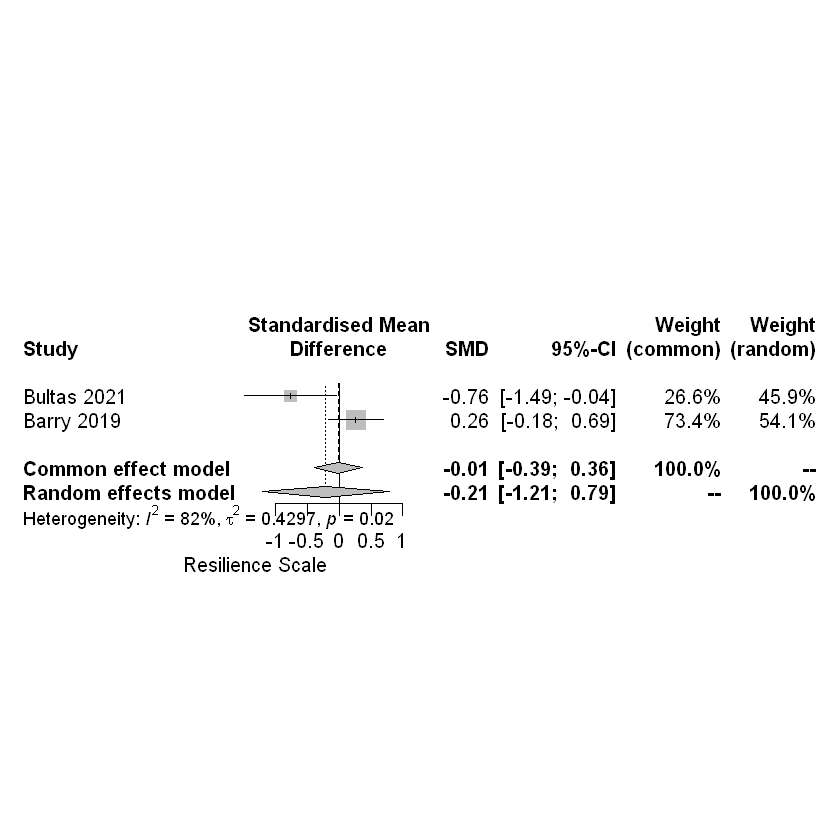

In [526]:
print.meta.results("Resilience Scale")

In [ ]:
for (outcome in present.outcomes){
  print(outcome)
  if (outcome == "Stress"){
    print.meta.results(
      outcome, preferred.scale = "Depression Anxiety and Stress Scale (DASS)", regression = FALSE, print.regression.results =F, print.meta.results = F
    )
    
    print.meta.results(
      outcome, preferred.scale = "Perceived Stress Scale (PSS)", regression = FALSE, print.regression.results =F, print.meta.results = F
    )
  } else {
    print.meta.results(outcome, regression = FALSE, print.regression.results =F, print.meta.results = F)
  }
    
  cat("######################################################\n\n")
}

In [ ]:
# all studies with stress
outcome.names.df %>%
  filter(
    "Stress" == Name.of.Outcome.1 |
    "Stress" == Name.of.Outcome.2 |
    "Stress" == Name.of.Outcome.3 |
    "Stress" == Name.of.Outcome.4 |
    "Stress" == Name.of.Outcome.5 |
    "Stress" == Name.of.Outcome.6 |
    "Stress" == Name.of.Outcome.7
  )

# Old Code

In [ ]:
# get.heterogeneity <- function(meta.results){
#   I2.found <- FALSE
#   for (line in capture.output(meta.results)){
#     # capture.output() gets output as character vector
#     if (
#       grepl("I\\^2", line) &
#       !grepl("%", substring(sub(".*I\\^2 = ", "", line), 1, 4)) &
#       is.double(suppressWarnings(as.double(substring(sub(".*I\\^2 = ", "", line), 1, 4))))
#         # substring(sub(".*I\\^2 = ", "", line), 1, 4) returns 1st four characters after I^2
#     ){
#       # for values >= 10 % (e.g., "15.5" = 4 characters)
#       I2.found <- TRUE
#       return(
#         as.double(substring(sub(".*I\\^2 = ", "", line), 1, 4))
#       )
#     } else if (
#       grepl("I\\^2", line) &
#       is.double(suppressWarnings(as.double(substring(sub(".*I\\^2 = ", "", line), 1, 3))))
#     ){
#       # for falues < 10 %
#       I2.found <- TRUE
#       return(
#         as.double(substring(sub(".*I\\^2 = ", "", line), 1, 3))
#       )
#     } else if (
#       grepl("I\\^2", line) &
#       !is.double(suppressWarnings(as.double(substring(sub(".*I\\^2 = ", "", line), 1, 4)))) &
#       !is.double(suppressWarnings(as.double(substring(sub(".*I\\^2 = ", "", line), 1, 3))))
#     ){
#       cat(
#         "unknown heterogeneity values:", "\n",
#         substring(sub(".*I\\^2 = ", "", line), 1, 4), "\n\n"
#       )
#     }
#   }
#   if (!I2.found){
#     print("no heterogeneity found")
#   }
# }


In [ ]:
# # regression without weights being considered!!!!!!!!!!!!!!!!!
# plot.meta.regression <- function(regression.df, regression.factor){
#   ggplot(
#     # set axis
#     data=regression.df,
#     aes(
#       x = !!sym(regression.factor),  # !!sym() makes it possible to pass string as argument
#       y = hedges.g,
#       size = weights
#     )
#   ) +
  
#   # add scatter plot
#   geom_point(
#     alpha = .5,
#     colour = "blue"
#   ) +
  
#   # label points
#   geom_text(aes(
#     label=study.id,
#     hjust=1,
#     vjust=-0.8,
#     size=0.45
#   )) +
  
#   # add vertical paddings to ensure labels are displayed completely
#   scale_x_continuous(expand = expansion(mult = 0.2)) +
  
#   # add regression line with confidence interval
#   geom_smooth(
#     method = lm,
#     se = TRUE,
#     size = 1,
#     alpha = .15,
#     fill = "#33638DFF") +
  
#   # add dashed line on 0 effect level  
#   geom_hline(
#     yintercept=0,
#     linetype="dashed",
#     color = "red",
#     size =0.5
#   ) +
  
#   # hide legend
#   theme(
#     legend.position = "none"
#   )
# }

In [ ]:
# # regression without weights being considered!!!!!!!!!!!!!!!!!
# print(1)
# regs <- c("sessions.duration", "sessions.frequency", "programs.duration", "delivery.mode")

# i <- 1
# reg <- regs[i]
# regression.df <- meta.analyze(
#   "Stress", meditation.type.all, m.data.list, time.point = 2,
#   preferred.scale = "Perceived Stress Scale (PSS)",
#   sort.by = "hedges.g", regression.factor = reg
# )

# plot.meta.regression(regression.df, reg)
# i <- i + 1

# reg <- regs[i]
# regression.df <- meta.analyze(
#   "Stress", meditation.type.all, m.data.list, time.point = 2,
#   preferred.scale = "Perceived Stress Scale (PSS)",
#   sort.by = "hedges.g", regression.factor = reg
# )

# plot.meta.regression(regression.df, reg)
# i <- i + 1

# reg <- regs[i]
# regression.df <- meta.analyze(
#   "Stress", meditation.type.all, m.data.list, time.point = 2,
#   preferred.scale = "Perceived Stress Scale (PSS)",
#   sort.by = "hedges.g", regression.factor = reg
# )

# plot.meta.regression(regression.df, reg)
# i <- i + 1

# reg <- regs[i]
# regression.df <- meta.analyze(
#   "Stress", meditation.type.all, m.data.list, time.point = 2,
#   preferred.scale = "Perceived Stress Scale (PSS)",
#   sort.by = "hedges.g", regression.factor = reg
# )

# plot.meta.regression(regression.df, reg)
# i <- i + 1


# print(2)

In [ ]:
# library('readxl')
# # import csv file into R
# # data <- read_excel('review_47966_20220515233722.xlsx')
# # write.csv(data, file = 'review_47966_20220515233722.csv')
# data <- read.csv('review_47966_20220515233722.csv')

# # create df of all Meditation 1 studies
# data.med1 =  data[data$Practiced.Techniques.in.Intervention.1 == 'Meditation 1', ] # select only rows with meditation 1 as intervetion 1


# # pooled.sd <- sqrt(((n1-1)*s1^2 + (n2-1)*s2^2) / (n1+n1-2))
# # mean.diff <- mean.1 - mean.2
# # cohens'd <- mean.diff/pooled.sd
# # calculate hedges g out of cohens d with hedges_g()

# # create df for meta analysis with Meditation 1
# library('esc')
# df.meta <- data.frame(
#   study.id =	data.med1[, 'Study.ID'],
#   number.meditation =	data.med1[, 'Sample.size.Intervention.1.T1'],  # number of participants in meditation condition
#   mean.meditation =	data.med1[, 'Intervention.1.Mean.T2'],
#   sd.meditation =	data.med1[, 'Intervention.1.SD.T2'],
#   number.control =	data.med1[, 'Sample.size.Intervention.2.T1'],
#   mean.conttrol	= data.med1[, 'Intervention.2.Mean.T2'],
#   sd.control	= data.med1[, 'Intervention.2.SD.T2'],
#   med.frequency = data.med1[, 'Frequency'],
#   pooled.sd = sqrt((data.med1[, 'Sample.size.Intervention.1.T1']-1)*data.med1[, 'Intervention.1.SD.T2']^2 + (data.med1[, 'Sample.size.Intervention.2.T1']-1)*data.med1[, 'Intervention.2.SD.T2']^2) / (data.med1[, 'Sample.size.Intervention.1.T1']+data.med1[, 'Sample.size.Intervention.1.T1']-2),
#   mean.diff.T2 = data.med1[, 'Intervention.1.Mean.T2']-data.med1[, 'Intervention.2.Mean.T2']
# )

# df.meta$hedges.g <- (df.meta[, "pooled.sd"] / df.meta[, "mean.diff.T2"])

# library('meta')
# res.df_meta =  metacont(number.meditation, mean.meditation, sd.meditation, 
#                         number.control, mean.conttrol, sd.control,
#                         fixed = T, random = T, studlab = study.id,
#                         data = df.meta, sm = "SMD")

# # plot forest plot
# forest(res.df_meta, leftcols = c('studlab'))

# # plot funnel plot
# funnel(res.df_meta)

# # metabias: Test for funnel plot asymmetry, based on rank correlation or linear regression method.
# metabias(res.df_meta, method.bias = 'linreg', k.min = , plotit = T)
# # The p-value is 0.973 which implies no publication bias. However, this meta-analysis contains k=5 studies. Egger’s test may lack the statistical power to detect bias when the number of studies is small (i.e., k<10).

# # conduct meta-regression, see: https://cjvanlissa.github.io/Doing-Meta-Analysis-in-R/plotting-regressions.html
# library('metafor')
# random.effects.model <- rma(
#   df.meta[, "hedges.g"],
#   df.meta[, "pooled.sd"]
# )
#   # second paramenter in rma-function = sampling variance = pooled standard deviation?

# install.packages('ggplot2')
# library(ggplot2)

# df.meta$weights <- 1/sqrt(df.meta$pooled.sd)
# # Specify basic plot, mapping med.frequency to the x-axis, effect size 'hedges.g' to the y-axis,
# # and 'weights' to the weight parameter.
# ggplot(df.meta, aes(x = med.frequency, y = hedges.g, size = weights)) +
#   geom_point(shape = 1) + # Add scatter
#   geom_abline(intercept = random.effects.model$b[1], slope = random.effects.model$b[2]) + # Add regression line
#   theme_bw() + # Apply black and white theme
#   theme(legend.position = "none") # Remove legend
#   # see link for beatiful meta-regression with convidence intervals: https://bookdown.org/robcrystalornelas/meta-analysis_of_ecological_data/meta-regression.html#meta-regression-with-continuous-variable

# # plot traffic light plot for RoB
# ## use {robvis} via the rob_traffic_light function
# ## see: https://bookdown.org/MathiasHarrer/Doing_Meta_Analysis_in_R/risk-of-bias-plots.html#traffic-light-plots

# # plot Summary Plots
# ## use use {robvis} via the rob_summary function

### Get no of included studies from meta results

In [ ]:
# # returns values of meta.results after search.term from start to end as double
# get.studies.no <- function(meta.results){
#   k.found <- FALSE
#   search.term <- "Number of studies combined: k = "
#   for (line in capture.output(meta.results)){
#     # capture.output() gets output as character vector
#     if (
#       grepl(search.term, line) &
#       is.double(suppressWarnings(as.double(sub(sprintf(".*%s", search.term), "", line))))
#         # sub(sprintf(".*%s", search.term), "", line) returns characters after search.term
#     ){
#       k.found <- TRUE
#       return(
#         as.double(sub(sprintf(".*%s", search.term), "", line))
#       )
#       break
#     }
#   }
#   if (!k.found){
#     print("no k found")
#   }
# }


## meta.analyze, fill.meta.df(), 

In [ ]:
# # for meta.analyze without descr..reg.data.list
# fill.meta.df <- function(
#   scale, time.point, intervention.no, outcome.no, study,
#   m.data.list, nm.placeholder, int.per.study
#   ){
# # Descriptive Results
# ## for control group
#   if (intervention.no == 4){
#     for (i in 1:int.per.study){
#       # if n interventions are included, these refer to the control n times
#       study.id <<- append(
#         study.id,
#         m.data.list[["one.D.info.df"]][study,"Study.ID"]
#       )

#       n.control <<- append(
#         n.control,
#         results.descriptive.array[intervention.no, "n", time.point, outcome.no, scale, study]
#       )
#       mean.control <<- append(
#         mean.control,
#         results.descriptive.array[intervention.no, "Mean", time.point, outcome.no, scale, study]
#       )
#       sd.control <<- append(
#         sd.control,
#         results.descriptive.array[intervention.no, "SD", time.point, outcome.no, scale, study]
#       )
#     }

# ## for intervention
#   } else {
#     # add descriptive results to respective vector
#     n.int <<- append(
#       n.int,
#       results.descriptive.array[intervention.no, "n", time.point, outcome.no, scale, study]
#     )
#     mean.int <<- append(
#       mean.int,
#       results.descriptive.array[intervention.no, "Mean", time.point, outcome.no, scale, study]
#     )
#     sd.int <<- append(
#       sd.int,
#       results.descriptive.array[intervention.no, "SD", time.point, outcome.no, scale, study]
#     )

#     int.per.study <<- int.per.study + 1

# # Results for meta-regression
#     sessions.duration <<- append(
#       sessions.duration,
#       get.regression.data(m.data.list, "Sessions.Duration.in.minutes", study, intervention.no, nm.placeholder)
#     )

#     sessions.frequency <<- append(
#       sessions.duration,
#       get.regression.data(m.data.list, "Frequency.in.times.per.week", study, intervention.no, nm.placeholder)
#     )

#     programs.duration <<- append(
#       sessions.duration,
#       get.regression.data(m.data.list, "Total.Duration.in.Days", study, intervention.no, nm.placeholder)
#     )

#     delivery.mode <<- append(
#       sessions.duration,
#       get.regression.data(m.data.list, "Delivery.Mode", study, intervention.no, nm.placeholder)
#     )
#   }
# }

In [ ]:
# # without fill.meta.df()
# meta.analyze <- function(
#   outcome, meditation.types, m.data.list, preferred.scale = FALSE,
#   print.forest = FALSE, print.funnel = FALSE, print.meta.results = FALSE,
#   print.descriptive = FALSE, moderator = FALSE,
#   return.data = FALSE, filter.forest..funnel.vec = FALSE, filter.regression.vec = FALSE, sort.by = FALSE
#     # meditation.types = vector of meditation types
#     # preferred.scale = preferred scale in case of 2 scales for one outcome (Stress)
#     # moderator returns regression df instead of printing because latter does not work for some reason
# ){
#   study.id <- c()

# # Set Variables
# ## Descriptive Results
#   n.int <- c()
#   n.control <- c()
#   mean.int <- c()
#   mean.control <- c()
#   sd.int <- c()
#   sd.control <- c()

# ## Meta-Regression Factors
#   # for active control groups with regression data, create vectors also for control group
#   # and insert them at the function's control group part
#   # for this script there are only passive controls that do not have regression data
#   sessions.duration <- c()
#   sessions.frequency <- c()
#   programs.duration <- c()
#   delivery.mode <- c()
  
#   follow.up.period.t1.t2 <- c()
#   follow.up.period.t1.t3 <- c()

# ## create list of all meta data vectors to pass it to fill.meta.df()
#   # arrays or data frames are not used to be able to append values to vectors separately 
#   descr..reg.data.list.t1 <- list(
#     study.id, n.int, n.control, mean.int, mean.control, sd.int, sd.control,
#     sessions.duration, sessions.frequency, programs.duration, delivery.mode,
#     follow.up.period.t1.t2, follow.up.period.t1.t3
#   )
  
#   names(descr..reg.data.list.t1) <- c(
#     "study.id", "n.int", "n.control", "mean.int", "mean.control", "sd.int", "sd.control",
#     "sessions.duration", "sessions.frequency", "programs.duration", "delivery.mode",
#     "follow.up.period.t1.t2", "follow.up.period.t1.t3"
#   )
  
#   descr..reg.data.list.t2 <- descr..reg.data.list.t1
  
#   descr..reg.data.list.t3 <- descr..reg.data.list.t1
  
#   descr..reg.data.list <- list(descr..reg.data.list.t1, descr..reg.data.list.t2, descr..reg.data.list.t3)

#   names(descr..reg.data.list) <- c("t1", "t2", "t3")
  
# #___For other than Stress (Outcomes with one scale per outcome per study)___#
#   if (preferred.scale == FALSE){
#     for (study in 1:study.no){
#       int.per.study <- 0
#       for (outcome.no in 1:7){
#         for (intervention.no in 1:4){
#           results.descriptive.array <- m.data.list[["results.descriptive.array"]]
#           if (
#             m.data.list[["outcome.names.df"]][study, sprintf("Name.of.Outcome.%d", outcome.no)] ==
#             outcome &
#             !(
#               is.na(m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"]) |
#               m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] == "NA" |
#               m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
#                 nm.placeholder |
#               m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
#                 as.character(nm.placeholder)
#             ) &
#             (
#               m.data.list[["meditation.techniques.df"]][study, intervention.no] %in% meditation.types |
#               ((TRUE %in% (m.data.list[["meditation.techniques.df"]][study,] %in% meditation.types)) &
#                intervention.no == 4)
#             ) &
#             !(
#               NA %in% results.descriptive.array[intervention.no,,time.point, outcome.no, "Scale.1", study] |
#               nm.placeholder %in% results.descriptive.array[intervention.no,,time.point, outcome.no, "Scale.1", study]
#             ) &
#             !(
#               NA %in% results.descriptive.array["Control",,time.point, outcome.no, "Scale.1", study] |
#               nm.placeholder %in% results.descriptive.array["Control",,time.point, outcome.no, "Scale.1", study]
#             )
#           ){
            
# # Descriptive Results
# ## For Control Group
#             if (intervention.no == 4){
#               for (i in 1:int.per.study){
#                 # if n interventions are included, these refer to the control n times
#                 study.id <- append(
#                   study.id,
#                   m.data.list[["one.D.info.df"]][study,"Study.ID"]
#                 )
                
#                 n.control <- append(
#                   n.control,
#                   results.descriptive.array[intervention.no, "n", time.point, outcome.no, "Scale.1", study]
#                 )
#                 mean.control <- append(
#                   mean.control,
#                   results.descriptive.array[intervention.no, "Mean", time.point, outcome.no, "Scale.1", study]
#                 )
#                 sd.control <- append(
#                   sd.control,
#                   results.descriptive.array[intervention.no, "SD", time.point, outcome.no, "Scale.1", study]
#                 )
#               }
            
# ## For Intervention
#             } else {
#               n.int <- append(
#                 n.int,
#                 results.descriptive.array[intervention.no, "n", time.point, outcome.no, "Scale.1", study]
#               )
#               mean.int <- append(
#                 mean.int,
#                 results.descriptive.array[intervention.no, "Mean", time.point, outcome.no, "Scale.1", study]
#               )
#               sd.int <- append(
#                 sd.int,
#                 results.descriptive.array[intervention.no, "SD", time.point, outcome.no, "Scale.1", study]
#               )
              
#               int.per.study <- int.per.study + 1
            
# # Results for Meta-Regression
#               sessions.duration <- append(
#                 sessions.duration,
#                 get.regression.data(m.data.list, "Sessions.Duration.in.minutes", study, intervention.no, nm.placeholder)
#               )
              
#               sessions.frequency <- append(
#                 sessions.duration,
#                 get.regression.data(m.data.list, "Frequency.in.times.per.week", study, intervention.no, nm.placeholder)
#               )
              
#               programs.duration <- append(
#                 sessions.duration,
#                 get.regression.data(m.data.list, "Total.Duration.in.Days", study, intervention.no, nm.placeholder)
#               )
              
#               delivery.mode <- append(
#                 sessions.duration,
#                 get.regression.data(m.data.list, "Delivery.Mode", study, intervention.no, nm.placeholder)
#               )
#             }
#           }
#         }
#       }
#     }

# #___For Stress (Sometimes 2 scales per study per outcome)___#
#   } else if (preferred.scale != FALSE){
#     for (study in 1:study.no){
#       int.per.study <- 0
#       for (time.point in 2:4){
#         for (scale in 1:2){
#           for (outcome.no in 1:7){
#             for (intervention.no in 1:4){
#               results.descriptive.array <- m.data.list[["results.descriptive.array"]]

#               if (
#                 m.data.list[["outcome.names.df"]][study, sprintf("Name.of.Outcome.%d", outcome.no)] == outcome &
#                 !(
#                   is.na(m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"]) |
#                   m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] == "NA" |
#                   m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] == nm.placeholder |
#                   m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
#                     as.character(nm.placeholder)
#                 ) &
#                 (
#                   m.data.list[["meditation.techniques.df"]][study, intervention.no] %in% meditation.types |
#                   ((TRUE %in% (m.data.list[["meditation.techniques.df"]][study,] %in% meditation.types)) & intervention.no == 4)
#                 ) &
#                 !(
#                   NA %in% results.descriptive.array[intervention.no,,time.point, outcome.no, scale, study] |
#                   nm.placeholder %in% results.descriptive.array[intervention.no,,time.point, outcome.no, scale, study]
#                 ) &
#                 !(
#                   NA %in% results.descriptive.array["Control",,time.point, outcome.no, scale, study] |
#                   nm.placeholder %in% results.descriptive.array["Control",,time.point, outcome.no, scale, study]
#                 )
#               ){

#   # skip iteration if 2 scales per outcome are present and current scale is not the preferred one
#                 scale.name <- m.data.list[["outcome.measures.df.list"]][[study]][sprintf("Outcome.%d", outcome.no),
#                   "Measures.Name"]
#                 if (multiple.commas.present(scale.name)){
#                   cat("multiple commas in scale name, find solution:", scale.name, "\n\n")
#                   next
#                 } else if (grepl(",", scale.name)){  # comma = 2 scales per outcome
#                   if (scale == 1){
#                     scale.name.substring <- sub(",.*", "", scale.name)
#                       # extracts substring before comma
#                     if (!grepl(gsub("([()])","\\\\\\1", preferred.scale), scale.name.substring)){
#                       # grepl(gsub("([()])","\\\\\\1", preferred.scale) makes parenthesis in preferred.scale searchable
#                       next
#                     }
#                   } else if (scale == 2){
#                     scale.name.substring <- sub(".*,", "", scale.name)
#                       # extracts substring after comma
#                     if (!grepl(gsub("([()])","\\\\\\1", preferred.scale), scale.name.substring)){
#                       next
#                     }
#                   }
#                 }

#   # Descriptive Results
#   ## for control group
#                 if (intervention.no == 4){
#                   for (i in 1:int.per.study){
#                     # if n interventions are included, these refer to the control n times
#                     descr..reg.data.list[[time.point - 1]][["study.id"]] <- append(
#                       # time.point - 1 because descr..reg.data.list starts at t1
#                       descr..reg.data.list[[time.point - 1]][["study.id"]],
#                       m.data.list[["one.D.info.df"]][study,"Study.ID"]
#                     )

#                     descr..reg.data.list[[time.point - 1]][["n.control"]] <- append(
#                       descr..reg.data.list[[time.point - 1]][["n.control"]],
#                       results.descriptive.array[intervention.no, "n", time.point, outcome.no, scale, study]
#                     )
#                     descr..reg.data.list[[time.point - 1]][["mean.control"]] <- append(
#                       descr..reg.data.list[[time.point - 1]][["mean.control"]],
#                       results.descriptive.array[intervention.no, "Mean", time.point, outcome.no, scale, study]
#                     )
#                     descr..reg.data.list[[time.point - 1]][["sd.control"]] <- append(
#                       descr..reg.data.list[[time.point - 1]][["sd.control"]],
#                       results.descriptive.array[intervention.no, "SD", time.point, outcome.no, scale, study]
#                     )
#                   }

#   ## for intervention
#                 } else {
#                   # add descriptive results to respective vector
#                   descr..reg.data.list[[time.point - 1]][["n.int"]] <- append(
#                     descr..reg.data.list[[time.point - 1]][["n.int"]],
#                     results.descriptive.array[intervention.no, "n", time.point, outcome.no, scale, study]
#                   )
#                   descr..reg.data.list[[time.point - 1]][["mean.int"]] <- append(
#                     descr..reg.data.list[[time.point - 1]][["mean.int"]],
#                     results.descriptive.array[intervention.no, "Mean", time.point, outcome.no, scale, study]
#                   )
#                   descr..reg.data.list[[time.point - 1]][["sd.int"]] <- append(
#                     descr..reg.data.list[[time.point - 1]][["sd.int"]],
#                     results.descriptive.array[intervention.no, "SD", time.point, outcome.no, scale, study]
#                   )

#                   int.per.study <- int.per.study + 1

#   # Results for meta-regression
#                   descr..reg.data.list[[time.point - 1]][["sessions.duration"]] <- append(
#                     descr..reg.data.list[[time.point - 1]][["sessions.duration"]],
#                     get.regression.data(m.data.list, "Sessions.Duration.in.minutes", study, intervention.no, nm.placeholder)
#                   )

#                   descr..reg.data.list[[time.point - 1]][["sessions.frequency"]] <- append(
#                     descr..reg.data.list[[time.point - 1]][["sessions.duration"]],
#                     get.regression.data(m.data.list, "Frequency.in.times.per.week", study, intervention.no, nm.placeholder)
#                   )

#                   descr..reg.data.list[[time.point - 1]][["programs.duration"]] <- append(
#                     descr..reg.data.list[[time.point - 1]][["programs.duration"]],
#                     get.regression.data(m.data.list, "Total.Duration.in.Days", study, intervention.no, nm.placeholder)
#                   )

#                   descr..reg.data.list[[time.point - 1]][["delivery.mode"]] <- append(
#                     descr..reg.data.list[[time.point - 1]][["delivery.mode"]],
#                     get.regression.data(m.data.list, "Delivery.Mode", study, intervention.no, nm.placeholder)
#                   )
#                 }
#               }
#             }
#           }
#         }
#       }
#     }
#   }

#   meta.df.list <- list()
  
#   for (time.point in 1:3){  # here 1 is post-test
    
#     n.control <- descr..reg.data.list[[time.point]][["n.control"]]
#     mean.control <- descr..reg.data.list[[time.point]][["mean.control"]]
#     sd.control <- descr..reg.data.list[[time.point]][["sd.control"]]
#     n.int <- descr..reg.data.list[[time.point]][["n.int"]]
#     mean.int <- descr..reg.data.list[[time.point]][["mean.int"]]
#     sd.int <- descr..reg.data.list[[time.point]][["sd.int"]]

#     sessions.duration <- descr..reg.data.list[[time.point]][["sessions.duration"]]
#     sessions.frequency <- descr..reg.data.list[[time.point]][["sessions.frequency"]]
#     programs.duration <- descr..reg.data.list[[time.point]][["programs.duration"]]
#     delivery.mode <- descr..reg.data.list[[time.point]][["delivery.mode"]]
    
#     pooled.sd <- sqrt((((n.int - 1) * sd.int^2) + ((n.control - 1) * sd.control^2)) / (n.int + n.control -2))
#     mean.diff <- mean.int - mean.control
#     hedges.g <- mean.diff / pooled.sd 
#     weights <- 1/sqrt(pooled.sd)

#     # correct not understdood bug (length(sessions.frequency) = length(sessions.duration) + 1)
#     if (length(sessions.frequency) == length(sessions.duration) + 1){
#       sessions.frequency <- sessions.frequency[2:length(sessions.frequency)]
#     }
#     if (length(programs.duration) == length(sessions.duration) + 1){
#       programs.duration <- programs.duration[2:length(programs.duration)]
#     }
#     if (length(delivery.mode) == length(sessions.duration) + 1){
#       delivery.mode <- delivery.mode[2:length(delivery.mode)]
#     }
    
#     meta.df.list <- append(
#       meta.df.list,
#       list(data.frame(  # data frame as to be in a list to append it to a list
#         study.id = descr..reg.data.list[[time.point]][["study.id"]],
#         n.control = descr..reg.data.list[[time.point]][["n.control"]],
#         mean.control = descr..reg.data.list[[time.point]][["mean.control"]],
#         sd.control = descr..reg.data.list[[time.point]][["sd.control"]],
#         n.int = descr..reg.data.list[[time.point]][["n.int"]],
#         mean.int = descr..reg.data.list[[time.point]][["mean.int"]],
#         sd.int = descr..reg.data.list[[time.point]][["sd.int"]],
#         pooled.sd = pooled.sd,
#         mean.diff = mean.diff,
#         hedges.g = hedges.g,
#         weights = weights,
#         sessions.duration = descr..reg.data.list[[time.point]][["sessions.duration"]],
#         sessions.frequency = descr..reg.data.list[[time.point]][["sessions.frequency"]],
#         programs.duration = descr..reg.data.list[[time.point]][["programs.duration"]],
#         delivery.mode = descr..reg.data.list[[time.point]][["delivery.mode"]]
#       ))
      
#     # sort studies
#       if (sort.by == "hedges.g"){
#         meta.df.list[[time.point]] <- arrange(meta.df.list[[time.point]], hedges.g)
#       } else if (sort.by == "name"){
#         meta.df.list[[time.point]] <- arrange(meta.df.list[[time.point]], study.id)
#       } else if (sort.by != FALSE){
#         cat('\n\nsort by "hedges.g" or "name"\n\n')
#       }

#     # filter for studies for clustering
#       if (!FALSE %in% filter.forest..funnel.vec){
#         meta.df.list[[time.point]] <- meta.df.list[[time.point]][filter.forest..funnel.vec,]
#       }
#     )
#   }
  
#   names(meta.df.list) <- c("t1", "t2", "t3")
  
# # get results df for forest plot {meta}
#   results.forest.df <- metacont(
#     n.int, mean.int, sd.int,
#     n.control, mean.control, sd.control,
#     fixed = T, random = T, studlab = study.id,
#     data = meta.df.list[[1]], sm = "SMD"
#   )

# # Forest plot and descriptive & meta-results
#   if (print.descriptive){
#     print(meta.df.list[[1]])
#   }

#   if (print.meta.results){
#     print(results.forest.df)
#   }

#   if (print.forest){
#     label.add <- ""
#     if (preferred.scale != FALSE){
#       if (grepl("PSS", preferred.scale)){
#         label.add <- " (prefrerred scale: PSS)"
#       } else if (grepl("DASS", preferred.scale)){
#         label.add <- " (prefrerred scale: DASS)"
#       } 
#     }
#     forest(
#       results.forest.df, leftcols = c('studlab'),
#       prediction = TRUE,
#       label.c = "Passive Control", label.e = "Meditation",
#       plotwidth = "4cm",
#       label.left = paste(outcome, label.add)
#     )
#   }

# # Funnel plot
#   # get results for funnel and meta-regression plot
#   results.funnel <- get.funnel..regression.results(meta.df.list[[1]])
#     # method argument is set default to:
#     # method="REML" = restricted maximum likelihood estimator (Viechtbauer, 2005; Raudenbush, 2009)
  
#   if (print.funnel){
#     # # with {meta}
#     # funnel(results.forest.df)

#     # with {metafor}
#     trim.and.fill <- trimfill(results.funnel)

#     funnel(
#       trim.and.fill, legend = TRUE, label = TRUE,
#       level=c(90, 95, 99), shade=c("white", "gray55", "gray75"), refline=0
#     )
#   }

# # Meta-Regression {metafor}
# ## Session's Duration
#   if (moderator != FALSE){
#     regression.df <- meta.df.list[[1]] %>%
#       filter(!is.na(!!sym(moderator)))
    
#     if (!FALSE %in% filter.regression.vec){
#       regression.df <- regression.df[filter.regression.vec,]
#     }
    
#     return(regression.df)
#   }

# # Return Results
#   if (return.data == "descriptive"){
#     return(meta.df.list[[1]])
#   } else if (return.data == "meta results"){
#     return(return.data == "results forest")
#   } else if (return.data == "hedges.g"){
#     return(meta.df.list[[1]][, "hedges.g"])
#   }
# }


In [ ]:
# # without descr..reg.data.list
# meta.analyze <- function(
#   outcome, meditation.types, m.data.list, time.point, preferred.scale = FALSE,
#   print.forest = FALSE, print.funnel = FALSE, print.meta.results = FALSE,
#   print.descriptive = FALSE, moderator = FALSE,
#   return.data = FALSE, filter.forest..funnel.vec = FALSE, filter.regression.vec = FALSE, sort.by = FALSE
#     # meditation.types = vector of meditation types
#     # preferred.scale = preferred scale in case of 2 scales for one outcome (Stress)
#     # moderator returns regression df instead of printing because latter does not work for some reason
# ){
#   study.id <<- c()

# # Set Variables
# ## Descriptive Results
#   n.int <<- c()
#   n.control <<- c()
#   mean.int <<- c()
#   mean.control <<- c()
#   sd.int <<- c()
#   sd.control <<- c()

# ## Meta-Regression Factors
#   # for active control groups with regression data, create vectors also for control group
#   # and insert them at the function's control group part
#   # for this script there are only passive controls that do not have regression data
#   sessions.duration <<- c()
#   sessions.frequency <<- c()
#   programs.duration <<- c()
#   delivery.mode <<- c()
  
#   follow.up.period.t1.t2 <<- c()
#   follow.up.period.t1.t3 <<- c()

# #___For other than Stress (Outcomes with one scale per outcome per study)___#
#   if (preferred.scale == FALSE){
#     for (study in 1:study.no){
#       int.per.study <- 0
#       for (outcome.no in 1:7){
#         for (intervention.no in 1:4){
#           results.descriptive.array <- m.data.list[["results.descriptive.array"]]
#           if (
#             m.data.list[["outcome.names.df"]][study, sprintf("Name.of.Outcome.%d", outcome.no)] ==
#             outcome &
#             !(
#               is.na(m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"]) |
#               m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] == "NA" |
#               m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
#                 nm.placeholder |
#               m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
#                 as.character(nm.placeholder)
#             ) &
#             (
#               m.data.list[["meditation.techniques.df"]][study, intervention.no] %in% meditation.types |
#               ((TRUE %in% (m.data.list[["meditation.techniques.df"]][study,] %in% meditation.types)) &
#                intervention.no == 4)
#             ) &
#             !(
#               NA %in% results.descriptive.array[intervention.no,,time.point, outcome.no, "Scale.1", study] |
#               nm.placeholder %in% results.descriptive.array[intervention.no,,time.point, outcome.no, "Scale.1", study]
#             ) &
#             !(
#               NA %in% results.descriptive.array["Control",,time.point, outcome.no, "Scale.1", study] |
#               nm.placeholder %in% results.descriptive.array["Control",,time.point, outcome.no, "Scale.1", study]
#             )
#           ){
            
# # Descriptive Results
# ## For Control Group
#             if (intervention.no == 4){
#               for (i in 1:int.per.study){
#                 # if n interventions are included, these refer to the control n times
#                 study.id <- append(
#                   study.id,
#                   m.data.list[["one.D.info.df"]][study,"Study.ID"]
#                 )
                
#                 n.control <- append(
#                   n.control,
#                   results.descriptive.array[intervention.no, "n", time.point, outcome.no, "Scale.1", study]
#                 )
#                 mean.control <- append(
#                   mean.control,
#                   results.descriptive.array[intervention.no, "Mean", time.point, outcome.no, "Scale.1", study]
#                 )
#                 sd.control <- append(
#                   sd.control,
#                   results.descriptive.array[intervention.no, "SD", time.point, outcome.no, "Scale.1", study]
#                 )
#               }
            
# ## For Intervention
#             } else {
#               n.int <- append(
#                 n.int,
#                 results.descriptive.array[intervention.no, "n", time.point, outcome.no, "Scale.1", study]
#               )
#               mean.int <- append(
#                 mean.int,
#                 results.descriptive.array[intervention.no, "Mean", time.point, outcome.no, "Scale.1", study]
#               )
#               sd.int <- append(
#                 sd.int,
#                 results.descriptive.array[intervention.no, "SD", time.point, outcome.no, "Scale.1", study]
#               )
              
#               int.per.study <- int.per.study + 1
            
# # Results for Meta-Regression
#               sessions.duration <- append(
#                 sessions.duration,
#                 get.regression.data(m.data.list, "Sessions.Duration.in.minutes", study, intervention.no, nm.placeholder)
#               )
              
#               sessions.frequency <- append(
#                 sessions.duration,
#                 get.regression.data(m.data.list, "Frequency.in.times.per.week", study, intervention.no, nm.placeholder)
#               )
              
#               programs.duration <- append(
#                 sessions.duration,
#                 get.regression.data(m.data.list, "Total.Duration.in.Days", study, intervention.no, nm.placeholder)
#               )
              
#               delivery.mode <- append(
#                 sessions.duration,
#                 get.regression.data(m.data.list, "Delivery.Mode", study, intervention.no, nm.placeholder)
#               )
#             }
#           }
#         }
#       }
#     }

# #___For Stress (Sometimes 2 scales per study per outcome)___#
#   } else if (preferred.scale != FALSE){
#     for (study in 1:study.no){
#       int.per.study <<- 0
#       for (scale in 1:2){
#         for (outcome.no in 1:7){
#           for (intervention.no in 1:4){
#             results.descriptive.array <- m.data.list[["results.descriptive.array"]]

#             if (
#               m.data.list[["outcome.names.df"]][study, sprintf("Name.of.Outcome.%d", outcome.no)] == outcome &
#               !(
#                 is.na(m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"]) |
#                 m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] == "NA" |
#                 m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] == nm.placeholder |
#                 m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
#                   as.character(nm.placeholder)
#               ) &
#               (
#                 m.data.list[["meditation.techniques.df"]][study, intervention.no] %in% meditation.types |
#                 ((TRUE %in% (m.data.list[["meditation.techniques.df"]][study,] %in% meditation.types)) & intervention.no == 4)
#               ) &
#               !(
#                 NA %in% results.descriptive.array[intervention.no,,time.point, outcome.no, scale, study] |
#                 nm.placeholder %in% results.descriptive.array[intervention.no,,time.point, outcome.no, scale, study]
#               ) &
#               !(
#                 NA %in% results.descriptive.array["Control",,time.point, outcome.no, scale, study] |
#                 nm.placeholder %in% results.descriptive.array["Control",,time.point, outcome.no, scale, study]
#               )
#             ){

# # skip iteration if 2 scales per outcome are present and current scale is not the preferred one
#               scale.name <- m.data.list[["outcome.measures.df.list"]][[study]][sprintf("Outcome.%d", outcome.no),
#                 "Measures.Name"]
#               if (multiple.commas.present(scale.name)){
#                 cat("multiple commas in scale name, find solution:", scale.name, "\n\n")
#                 next
#               } else if (grepl(",", scale.name)){  # comma = 2 scales per outcome
#                 if (scale == 1){
#                   scale.name.substring <- sub(",.*", "", scale.name)
#                     # extracts substring before comma
#                   if (!grepl(gsub("([()])","\\\\\\1", preferred.scale), scale.name.substring)){
#                     # grepl(gsub("([()])","\\\\\\1", preferred.scale) makes parenthesis in preferred.scale searchable
#                     next
#                   }
#                 } else if (scale == 2){
#                   scale.name.substring <- sub(".*,", "", scale.name)
#                     # extracts substring after comma
#                   if (!grepl(gsub("([()])","\\\\\\1", preferred.scale), scale.name.substring)){
#                     next
#                   }
#                 }
#               }
#               fill.meta.df(
#                 scale, time.point, intervention.no, outcome.no, study,
#                 m.data.list, nm.placeholder, int.per.study
#               )
#             }
#           }
#         }
#       }
#     }
#   }

#   pooled.sd <- sqrt((((n.int - 1) * sd.int^2) + ((n.control - 1) * sd.control^2)) / (n.int + n.control -2))
#   mean.diff <- mean.int - mean.control
#   hedges.g <- mean.diff / pooled.sd 
#   weights <- 1/sqrt(pooled.sd)
  
#   # correct not understdood bug (length(sessions.frequency) = length(sessions.duration) + 1)
#   if (length(sessions.frequency) == length(sessions.duration) + 1){
#     sessions.frequency <- sessions.frequency[2:length(sessions.frequency)]
#   }
#   if (length(programs.duration) == length(sessions.duration) + 1){
#     programs.duration <- programs.duration[2:length(programs.duration)]
#   }
#   if (length(delivery.mode) == length(sessions.duration) + 1){
#     delivery.mode <- delivery.mode[2:length(delivery.mode)]
#   }
  
#   meta.df <- data.frame(
#     study.id =	study.id,
#     n.control =	n.control,
#     mean.control =	mean.control,
#     sd.control =	sd.control,
#     n.int =	n.int,
#     mean.int	= mean.int,
#     sd.int	= sd.int,
#     pooled.sd = pooled.sd,
#     mean.diff = mean.diff,
#     hedges.g = hedges.g,
#     weights = weights,
#     sessions.duration = sessions.duration,
#     sessions.frequency = sessions.frequency,
#     programs.duration = programs.duration,
#     delivery.mode = delivery.mode
#   )

# # sort studies
#   if (sort.by == "hedges.g"){
#     meta.df <- arrange(meta.df, hedges.g)
#   } else if (sort.by == "name"){
#     meta.df <- arrange(meta.df, study.id)
#   } else if (sort.by != FALSE){
#     cat('\n\nsort by "hedges.g" or "name"\n\n')
#   }

# # filter for studies for clustering
#   if (!FALSE %in% filter.forest..funnel.vec){
#     meta.df <- meta.df[filter.forest..funnel.vec,]
#   }
  
# # get results df for forest plot {meta}
#   results.forest.df <- metacont(
#     n.int, mean.int, sd.int,
#     n.control, mean.control, sd.control,
#     fixed = T, random = T, studlab = study.id,
#     data = meta.df, sm = "SMD"
#   )

# # Forest plot and descriptive & meta-results
#   if (print.descriptive){
#     print(meta.df)
#   }

#   if (print.meta.results){
#     print(results.forest.df)
#   }

#   if (print.forest){
#     label.add <- ""
#     if (preferred.scale != FALSE){
#       if (grepl("PSS", preferred.scale)){
#         label.add <- " (prefrerred scale: PSS)"
#       } else if (grepl("DASS", preferred.scale)){
#         label.add <- " (prefrerred scale: DASS)"
#       } 
#     }
#     forest(
#       results.forest.df, leftcols = c('studlab'),
#       prediction = TRUE,
#       label.c = "Passive Control", label.e = "Meditation",
#       plotwidth = "4cm",
#       label.left = paste(outcome, label.add)
#     )
#   }

# # Funnel plot
#   # get results for funnel and meta-regression plot
#   results.funnel <- get.funnel..regression.results(meta.df)
#     # method argument is set default to:
#     # method="REML" = restricted maximum likelihood estimator (Viechtbauer, 2005; Raudenbush, 2009)
  
#   if (print.funnel){
#     # # with {meta}
#     # funnel(results.forest.df)

#     # with {metafor}
#     trim.and.fill <- trimfill(results.funnel)

#     funnel(
#       trim.and.fill, legend = TRUE, label = TRUE,
#       level=c(90, 95, 99), shade=c("white", "gray55", "gray75"), refline=0
#     )
#   }

# # Meta-Regression {metafor}
# ## Session's Duration
#   if (moderator != FALSE){
#     regression.df <- meta.df %>%
#       filter(!is.na(!!sym(moderator)))
    
#     if (!FALSE %in% filter.regression.vec){
#       regression.df <- regression.df[filter.regression.vec,]
#     }
    
#     return(regression.df)
#   }

# # Return Results
#   if (return.data == "descriptive"){
#     return(meta.df)
#   } else if (return.data == "meta results"){
#     return(return.data == "results forest")
#   } else if (return.data == "hedges.g"){
#     return(meta.df[, "hedges.g"])
#   }
# }


In [ ]:
# # old working
# meta.analyze <- function(
#   outcome, meditation.types, m.data.list, time.point, preferred.scale = FALSE,
#   print.forest = FALSE, print.funnel = FALSE, print.meta.results = FALSE,
#   print.descriptive = FALSE, moderator = FALSE,
#   return.data = FALSE, filter.forest..funnel.vec = FALSE, filter.regression.vec = FALSE, sort.by = FALSE
#     # meditation.types = vector of meditation types
#     # preferred.scale = preferred scale in case of 2 scales for one outcome (Stress)
#     # moderator returns regression df instead of printing because latter does not work for some reason
# ){
#   study.id <- c()

# # Set Variables
# ## Descriptive Results
#   n.int <- c()
#   n.control <- c()
#   mean.int <- c()
#   mean.control <- c()
#   sd.int <- c()
#   sd.control <- c()

# ## Meta-Regression Factors
#   # for active control groups with regression data, create vectors also for control group
#   # and insert them at the function's control group part
#   # for this script there are only passive controls that do not have regression data
#   sessions.duration <- c()
#   sessions.frequency <- c()
#   programs.duration <- c()
#   delivery.mode <- c()
  
#   follow.up.period.t1.t2 <- c()
#   follow.up.period.t1.t3 <- c()

# #___For other than Stress (Outcomes with one scale per outcome per study)___#
#   if (preferred.scale == FALSE){
#     for (study in 1:study.no){
#       int.per.study <- 0
#       for (outcome.no in 1:7){
#         for (intervention.no in 1:4){
#           results.descriptive.array <- m.data.list[["results.descriptive.array"]]
#           if (
#             m.data.list[["outcome.names.df"]][study, sprintf("Name.of.Outcome.%d", outcome.no)] ==
#             outcome &
#             !(
#               is.na(m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"]) |
#               m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] == "NA" |
#               m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
#                 nm.placeholder |
#               m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
#                 as.character(nm.placeholder)
#             ) &
#             (
#               m.data.list[["meditation.techniques.df"]][study, intervention.no] %in% meditation.types |
#               ((TRUE %in% (m.data.list[["meditation.techniques.df"]][study,] %in% meditation.types)) &
#                intervention.no == 4)
#             ) &
#             !(
#               NA %in% results.descriptive.array[intervention.no,,time.point, outcome.no, "Scale.1", study] |
#               nm.placeholder %in% results.descriptive.array[intervention.no,,time.point, outcome.no, "Scale.1", study]
#             ) &
#             !(
#               NA %in% results.descriptive.array["Control",,time.point, outcome.no, "Scale.1", study] |
#               nm.placeholder %in% results.descriptive.array["Control",,time.point, outcome.no, "Scale.1", study]
#             )
#           ){
            
# # Descriptive Results
# ## For Control Group
#             if (intervention.no == 4){
#               for (i in 1:int.per.study){
#                 # if n interventions are included, these refer to the control n times
#                 study.id <- append(
#                   study.id,
#                   m.data.list[["one.D.info.df"]][study,"Study.ID"]
#                 )
                
#                 n.control <- append(
#                   n.control,
#                   results.descriptive.array[intervention.no, "n", time.point, outcome.no, "Scale.1", study]
#                 )
#                 mean.control <- append(
#                   mean.control,
#                   results.descriptive.array[intervention.no, "Mean", time.point, outcome.no, "Scale.1", study]
#                 )
#                 sd.control <- append(
#                   sd.control,
#                   results.descriptive.array[intervention.no, "SD", time.point, outcome.no, "Scale.1", study]
#                 )
#               }
            
# ## For Intervention
#             } else {
#               n.int <- append(
#                 n.int,
#                 results.descriptive.array[intervention.no, "n", time.point, outcome.no, "Scale.1", study]
#               )
#               mean.int <- append(
#                 mean.int,
#                 results.descriptive.array[intervention.no, "Mean", time.point, outcome.no, "Scale.1", study]
#               )
#               sd.int <- append(
#                 sd.int,
#                 results.descriptive.array[intervention.no, "SD", time.point, outcome.no, "Scale.1", study]
#               )
              
#               int.per.study <- int.per.study + 1
            
# # Results for Meta-Regression
#               sessions.duration <- append(
#                 sessions.duration,
#                 get.regression.data(m.data.list, "Sessions.Duration.in.minutes", study, intervention.no, nm.placeholder)
#               )
              
#               sessions.frequency <- append(
#                 sessions.frequency,
#                 get.regression.data(m.data.list, "Frequency.in.times.per.week", study, intervention.no, nm.placeholder)
#               )
              
#               programs.duration <- append(
#                 programs.duration,
#                 get.regression.data(m.data.list, "Total.Duration.in.Days", study, intervention.no, nm.placeholder)
#               )
              
#               delivery.mode <- append(
#                 delivery.mode,
#                 get.regression.data(m.data.list, "Delivery.Mode", study, intervention.no, nm.placeholder)
#               )
#             }
#           }
#         }
#       }
#     }

# #___For Stress (Sometimes 2 scales per study per outcome)___#
#   } else if (preferred.scale != FALSE){
#     for (study in 1:study.no){
#       int.per.study <- 0
#       for (scale in 1:2){
#         for (outcome.no in 1:7){
#           for (intervention.no in 1:4){
#             results.descriptive.array <- m.data.list[["results.descriptive.array"]]

#             if (
#               m.data.list[["outcome.names.df"]][study, sprintf("Name.of.Outcome.%d", outcome.no)] == outcome &
#               !(
#                 is.na(m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"]) |
#                 m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] == "NA" |
#                 m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] == nm.placeholder |
#                 m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
#                   as.character(nm.placeholder)
#               ) &
#               (
#                 m.data.list[["meditation.techniques.df"]][study, intervention.no] %in% meditation.types |
#                 ((TRUE %in% (m.data.list[["meditation.techniques.df"]][study,] %in% meditation.types)) & intervention.no == 4)
#               ) &
#               !(
#                 NA %in% results.descriptive.array[intervention.no,,time.point, outcome.no, scale, study] |
#                 nm.placeholder %in% results.descriptive.array[intervention.no,,time.point, outcome.no, scale, study]
#               ) &
#               !(
#                 NA %in% results.descriptive.array["Control",,time.point, outcome.no, scale, study] |
#                 nm.placeholder %in% results.descriptive.array["Control",,time.point, outcome.no, scale, study]
#               )
#             ){

# # skip iteration if 2 scales per outcome are present and current scale is not the preferred one
#               scale.name <- m.data.list[["outcome.measures.df.list"]][[study]][sprintf("Outcome.%d", outcome.no),
#                 "Measures.Name"]
#               if (multiple.commas.present(scale.name)){
#                 cat("multiple commas in scale name, find solution:", scale.name, "\n\n")
#                 next
#               } else if (grepl(",", scale.name)){  # comma = 2 scales per outcome
#                 if (scale == 1){
#                   scale.name.substring <- sub(",.*", "", scale.name)
#                     # extracts substring before comma
#                   if (!grepl(gsub("([()])","\\\\\\1", preferred.scale), scale.name.substring)){
#                     # grepl(gsub("([()])","\\\\\\1", preferred.scale) makes parenthesis in preferred.scale searchable
#                     next
#                   }
#                 } else if (scale == 2){
#                   scale.name.substring <- sub(".*,", "", scale.name)
#                     # extracts substring after comma
#                   if (!grepl(gsub("([()])","\\\\\\1", preferred.scale), scale.name.substring)){
#                     next
#                   }
#                 }
#               }

# # Descriptive Results
# ## for control group
#               if (intervention.no == 4){
#                 for (i in 1:int.per.study){
#                   # if n interventions are included, these refer to the control n times
#                   study.id <- append(
#                     study.id,
#                     m.data.list[["one.D.info.df"]][study,"Study.ID"]
#                   )
                  
#                   n.control <- append(
#                     n.control,
#                     results.descriptive.array[intervention.no, "n", time.point, outcome.no, scale, study]
#                   )
#                   mean.control <- append(
#                     mean.control,
#                     results.descriptive.array[intervention.no, "Mean", time.point, outcome.no, scale, study]
#                   )
#                   sd.control <- append(
#                     sd.control,
#                     results.descriptive.array[intervention.no, "SD", time.point, outcome.no, scale, study]
#                   )
#                 }
              
# ## for intervention
#               } else {
#                 # add descriptive results to respective vector
#                 n.int <- append(
#                   n.int,
#                   results.descriptive.array[intervention.no, "n", time.point, outcome.no, scale, study]
#                 )
#                 mean.int <- append(
#                   mean.int,
#                   results.descriptive.array[intervention.no, "Mean", time.point, outcome.no, scale, study]
#                 )
#                 sd.int <- append(
#                   sd.int,
#                   results.descriptive.array[intervention.no, "SD", time.point, outcome.no, scale, study]
#                 )
                
#                 int.per.study <- int.per.study + 1
              
# # Results for meta-regression
#                 sessions.duration <- append(
#                   sessions.duration,
#                   get.regression.data(m.data.list, "Sessions.Duration.in.minutes", study, intervention.no, nm.placeholder)
#                 )
                
#                 sessions.frequency <- append(
#                   sessions.duration,
#                   get.regression.data(m.data.list, "Frequency.in.times.per.week", study, intervention.no, nm.placeholder)
#                 )
                
#                 programs.duration <- append(
#                   sessions.duration,
#                   get.regression.data(m.data.list, "Total.Duration.in.Days", study, intervention.no, nm.placeholder)
#                 )
                
#                 delivery.mode <- append(
#                   sessions.duration,
#                   get.regression.data(m.data.list, "Delivery.Mode", study, intervention.no, nm.placeholder)
#                 )
#               }
#             }
#           }
#         }
#       }
#     }
#   }

#   pooled.sd <- sqrt((((n.int - 1) * sd.int^2) + ((n.control - 1) * sd.control^2)) / (n.int + n.control -2))
#   mean.diff <- mean.int - mean.control
#   hedges.g <- mean.diff / pooled.sd 
#   weights <- 1/sqrt(pooled.sd)
  
#   # correct not understdood bug (length(sessions.frequency) = length(sessions.duration) + 1)
#   if (length(sessions.frequency) == length(sessions.duration) + 1){
#     sessions.frequency <- sessions.frequency[2:length(sessions.frequency)]
#   }
#   if (length(programs.duration) == length(sessions.duration) + 1){
#     programs.duration <- programs.duration[2:length(programs.duration)]
#   }
#   if (length(delivery.mode) == length(sessions.duration) + 1){
#     delivery.mode <- delivery.mode[2:length(delivery.mode)]
#   }
  
#   meta.df <- data.frame(
#     study.id =	study.id,
#     n.control =	n.control,
#     mean.control =	mean.control,
#     sd.control =	sd.control,
#     n.int =	n.int,
#     mean.int	= mean.int,
#     sd.int	= sd.int,
#     pooled.sd = pooled.sd,
#     mean.diff = mean.diff,
#     hedges.g = hedges.g,
#     weights = weights,
#     sessions.duration = sessions.duration,
#     sessions.frequency = sessions.frequency,
#     programs.duration = programs.duration,
#     delivery.mode = delivery.mode
#   )

# # sort studies
#   if (sort.by == "hedges.g"){
#     meta.df <- arrange(meta.df, hedges.g)
#   } else if (sort.by == "name"){
#     meta.df <- arrange(meta.df, study.id)
#   } else if (sort.by != FALSE){
#     cat('\n\nsort by "hedges.g" or "name"\n\n')
#   }

# # filter for studies for clustering
#   if (!FALSE %in% filter.forest..funnel.vec){
#     meta.df <- meta.df[filter.forest..funnel.vec,]
#   }
  
# # get results df for forest plot {meta}
#   results.forest.df <- metacont(
#     n.int, mean.int, sd.int,
#     n.control, mean.control, sd.control,
#     fixed = T, random = T, studlab = study.id,
#     data = meta.df, sm = "SMD"
#   )

# # Forest plot and descriptive & meta-results
#   if (print.descriptive){
#     print(meta.df)
#   }

#   if (print.meta.results){
#     print(results.forest.df)
#   }

#   if (print.forest){
#     label.add <- ""
#     if (preferred.scale != FALSE){
#       if (grepl("PSS", preferred.scale)){
#         label.add <- " (prefrerred scale: PSS)"
#       } else if (grepl("DASS", preferred.scale)){
#         label.add <- " (prefrerred scale: DASS)"
#       } 
#     }
#     forest(
#       results.forest.df, leftcols = c('studlab'),
#       prediction = TRUE,
#       label.c = "Passive Control", label.e = "Meditation",
#       plotwidth = "4cm",
#       label.left = paste(outcome, label.add)
#     )
#   }

# # Funnel plot
#   # get results for funnel and meta-regression plot
#   results.funnel <- get.funnel..regression.results(meta.df)
#     # method argument is set default to:
#     # method="REML" = restricted maximum likelihood estimator (Viechtbauer, 2005; Raudenbush, 2009)
  
#   if (print.funnel){
#     # # with {meta}
#     # funnel(results.forest.df)

#     # with {metafor}
#     trim.and.fill <- trimfill(results.funnel)

#     funnel(
#       trim.and.fill, legend = TRUE, label = TRUE,
#       level=c(90, 95, 99), shade=c("white", "gray55", "gray75"), refline=0
#     )
#   }

# # Meta-Regression {metafor}
# ## Session's Duration
#   if (moderator != FALSE){
#     regression.df <- meta.df %>%
#       filter(!is.na(!!sym(moderator)))
    
#     if (!FALSE %in% filter.regression.vec){
#       regression.df <- regression.df[filter.regression.vec,]
#     }
    
#     return(regression.df)
#   }

# # Return Results
#   if (return.data == "descriptive"){
#     return(meta.df)
#   } else if (return.data == "meta results"){
#     return(return.data == "results forest")
#   } else if (return.data == "hedges.g"){
#     return(meta.df[, "hedges.g"])
#   }
# }


In [ ]:
# # for meta.analyze() without descr..reg.data.list
# print.meta.results <- function(
#   outcome,
#   moderator.vec = c("sessions.duration", "sessions.frequency", "programs.duration"),
#   preferred.scale = FALSE
# ){
#   meta.analyze(
#     outcome, meditation.type.all, m.data.list, time.point = 2, print.forest = TRUE,
#     print.funnel = TRUE,  preferred.scale = preferred.scale,  sort.by = "hedges.g",
#     print.descriptive = TRUE
#   )
#   for (moderator in moderator.vec){
    
#     regression.df <- meta.analyze(
#       outcome, meditation.type.all, m.data.list, time.point = 2, preferred.scale = preferred.scale,
#       moderator = moderator
#     )
    
#     results.regression <- get.funnel..regression.results(
#       regression.df, moderator = moderator
#     )

#     regplot(
#       results.regression,
#       refline=0,
#       # xlim = c(0,60), predlim = c(0,60),
#       label=TRUE
#     )

#     print(results.regression)
#   }
# }

### Get no of included studies from meta results

In [ ]:
# # returns values of meta.results after search.term from start to end as double
# get.studies.no <- function(meta.results){
#   k.found <- FALSE
#   search.term <- "Number of studies combined: k = "
#   for (line in capture.output(meta.results)){
#     # capture.output() gets output as character vector
#     if (
#       grepl(search.term, line) &
#       is.double(suppressWarnings(as.double(sub(sprintf(".*%s", search.term), "", line))))
#         # sub(sprintf(".*%s", search.term), "", line) returns characters after search.term
#     ){
#       k.found <- TRUE
#       return(
#         as.double(sub(sprintf(".*%s", search.term), "", line))
#       )
#       break
#     }
#   }
#   if (!k.found){
#     print("no k found")
#   }
# }


# Notes
- Different Scales
    - 2 Array-Dims with same values
    - Results in Dim "Scale.2" only if 2nd scale is present, else: NA

- Ignore 2nd scale entry for Sloan 2016 

# ToDo
- find solution for
  - value: '3.79 during intervention, 2.04 during follow-up mean' in "Frequency.of.intervention.sessions.in.times.per.week.Intervention.1"

- Check error in creating outcome.measures.df.list:
    Warning message in convert.value(value, nm.placeholder, only.double = FALSE):
"NAs durch Umwandlung erzeugt"

- check if theresa has corrected my errors I have noticed

- calculate meta-regression for outcomes k <=10

- qualitative ergebnisse auswerten

- nochmal checken wie viele messzeitpunkte 'Sloan 2016' hat

- make get.regression.data() work for follow up periods

- check if correction in bug of meta.analyze() (line 260 [(length(sessions.frequency) = length(sessions.duration) + 1)]) is correct for all moderators
    
- make meta.analyze()'s regression results work follow up period
